<h1 style="text-align:center">
    E-commerce: análisis y predicción de ventas
</h1>


Vamos a explorar, en el presente notebook, los datos de ventas de una tienda e-commerce con sede en el Reino Unido (UK). El conjunto de datos disponible en UCI Machine Learning Repository - https://archive.ics.uci.edu/ml/datasets/online+retail - contiene:

- 541909 filas y 8 columnas.
- Período de transacciones: del 1 de diciembre de 2010 al 9 de diciembre de 2011 (1 año).
- Empresa: tienda e-commerce y con sede en el Reino Unido (UK).
- Productos: principalmente regalos.
- Clientes: locales e internacionales (37 países).



### Objetivos: 

- Crear un análisis descriptivo del conjunto.
- Realizar las transformaciones más adecuadas.
- Segmentar clientes usando RFM.
- Crear modelos de predicción - predecir las ventas - utilizando diferentes técnicas de modelización.

### Indíce


**1. Librerías y datos**

**2. EDA**

   - 2.1 Primeras observaciones 
   - 2.2 Tipos de datos
   - 2.3 Valores nulos
   - 2.4 Analizar las columnas por separado
       * 2.4.1 'InvoiceNo'
       * 2.4.2 'StockCode'
       * 2.4.3 'Description'
       * 2.4.4 'Quantity'
       * 2.4.5 'InvoiceDate'
       * 2.4.6 'UnitPrice'
       * 2.4.7 'CustomerID'
       * 2.4.8 'Country'         
   - 2.5 Consumidores y productos
       * 2.5.1 Pedidos cancelados
       * 2.5.2 Análisis de ventas mensuales
       * 2.5.3 Análisis de ventas semanales
       * 2.5.4 Productos más vendidos
       
**3. Limpieza de datos**

   - 3.1 Eliminar valores nulos 
   - 3.2 Eliminar valores negativos
   - 3.3 Detectar y eliminar valores atípicos
   - 3.4 Cast datetime
   - 3.5 Comprobamos la limpieza de los datos

**4. Series temporales**

   - 4.1 Analizar las ventas 
   - 4.2 Ventas por países
   - 4.3 Ventas y su distribución en el tiempo
   
**5. Análisis RFM**

   - 5.1 Recencia 
   - 5.2 Frequencia
   - 5.3 Monetario
   - 5.4 Tabla RFM
   - 5.5 Segmentamos los clientes con RFM

**6. Predecir las ventas**

   - 6.1 Transformaciones
   - 6.2 Intervalos 'Quantity' y 'UnitPrice'  
   - 6.3 Extraer fechas 
   - 6.4 Preparar datos para modelos 
       * 6.4.1 Separar datos en UK y non-UK 
       * 6.4.2 Extraer features para crear variables dummies
       * 6.4.3 Scaling 
   - 6.5 Train Test Split
   - 6.6 Modelos
       * 6.6.1 Linear Regression
       * 6.6.2 Bayesian Ridges
       * 6.6.3 Árbol de decisión
       * 6.6.4 Random Forest Regressor
       * 6.6.5 KNeighbors Regressor
   - 6.7 Evaluación modelos
       * 6.7.1 Report
       * 6.7.2 Predicciones
   - 6.8 Automatización de modelo
   - 6.9 Productivizar modelo

**7. Conclusiones**

## 1 - Librerías y datos

In [1]:
# Importamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import missingno as msno

sns.set()
import plotly 

from matplotlib import pylab
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *

Importamos nuestros datos usando el método .read_csv y añadimos el parámetro "encoding = 'latin'", ya que la codificación predeterminada no nos ha permitido cargar nuestro conjunto de datos.

In [2]:
# Importamos los datos con .read_csv () y añadimos "encoding = 'latin'
df = pd.read_csv('data.csv', encoding ='latin')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# df_limp se utilizará más adelante en la parte limpieza de datos
df_limp = df.copy()

En primer lugar, observamos la estructura general y los tipos de datos del conjunto de datos. 

In [4]:
# Info sobre el df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Tenemos 541909 filas y 8 columnas: la mayoría son categóricas pero también numéricas. Por otro lado, constatamos en un primer momento que es probable que tengamos que convertir 'InvoiceDate' a fecha y hora más adelante.

# 2 - EDA

- Trataremos de explorar y visualizar los datos a través de una investigación exhaustiva.

- Trataremos también de detectar cualquier anomalía para no introducir datos incorrectos en nuestro modelo.

## 2.1 - Primeras observaciones 

In [5]:
# Variables numéricas
numerical_vars = [col for col in df.columns if 
                df[col].dtype in ['int64', 'float64']]
numerical_vars

['Quantity', 'UnitPrice', 'CustomerID']

In [6]:
# Variables numéricas 
len(numerical_vars)

3

In [7]:
# Resumen variables numéricas 
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Analizamos los datos con .describe ():

- Observamos en primer lugar que "Quantity" y "UnitPrice" contienen datos negativos. 
- Parece que la mayoría de las transacciones son para cantidades de 3 a 10 productos y que la mayoría de los artículos tienen un precio de hasta 5 pounds.
- También tenemos valores atípicos importantes. Tendremos que eliminarlos en la parte limpieza de datos.

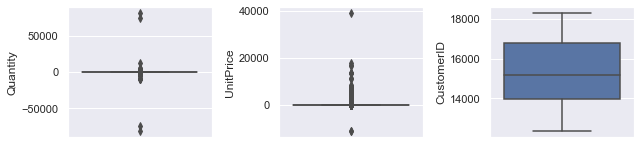

In [8]:
# Diagramas de caja para atributos numéricos
fig = plt.figure(figsize=(12, 18))

for i in range(len(numerical_vars)):
    fig.add_subplot(9, 4, i+1)
    sns.boxplot(y=df[numerical_vars].iloc[:,i])

plt.tight_layout()
plt.show()

Vemos arriba los valores atípicos importantes de "Quantity" y "UnitPrice".

In [9]:
# Observación general con describe "all"
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,NaN,NaN,NaN,15287.7,1713.6,12346,13953,15152,16791,18287
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Primeras observaciones:

- Hay una cantidad significativa de valores NaN.
- Observamos que tenemos valores negativos, así como valores atípicos importantes.

## 2.2 - Tipos de datos

In [10]:
# Comprobamos types
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

'dtypes' nos ayuda a entender los tipos de datos que tenemos. En este caso, no nos aporta más de lo que ya hemos observado, así que de momento seguimos con el analísis antes de tomar cualquier decisión de cara a la limpieza de datos.

## 2.3 - Valores nulos

In [11]:
# Valores nulos
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

'CustomerID' y 'Description' tienen ambos valores nulos. 'CustomerID' tiene demasiados valores nulos y parece que dicha variable no puede predecir mucho.

In [12]:
# Porcentajes valores nulos
missing_percentage = df.isnull().sum() / df.shape[0] * 100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Casi el 25% de los clientes son desconocidos. Además, el 0,27% de las descripciones faltan.

In [13]:
# Nombre de las columnas con valores nulos
df.columns[df.isnull().any()]

Index(['Description', 'CustomerID'], dtype='object')

<AxesSubplot:>

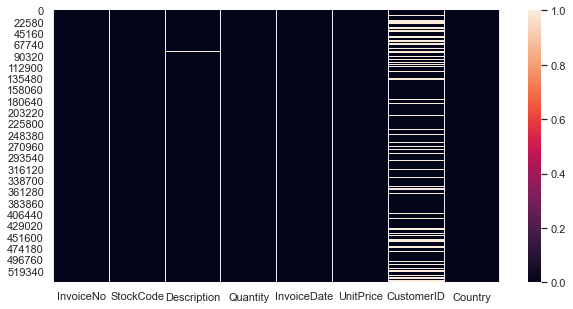

In [14]:
# Heatmap valores nulos
plt.subplots(figsize=(10,5))
sns.heatmap(df.isnull())

<AxesSubplot:>

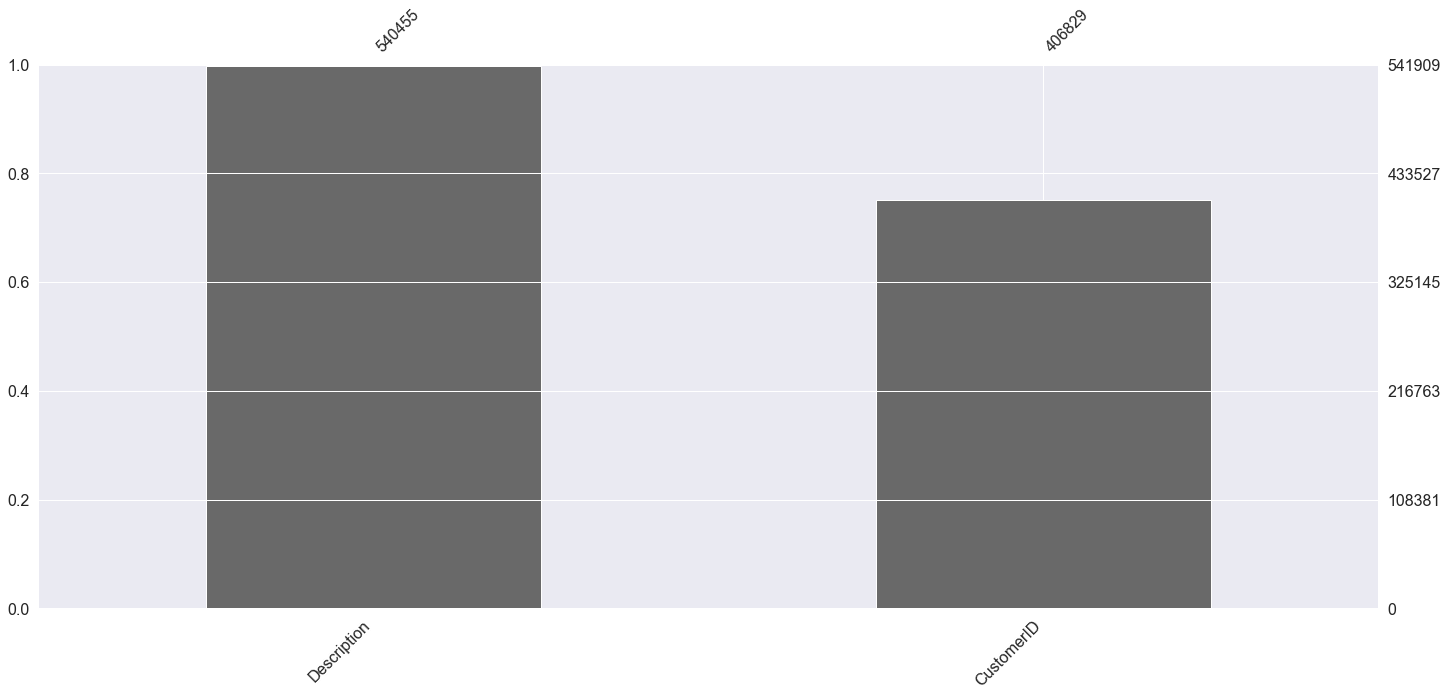

In [15]:
# Plot valores nulos
plt.subplots(figsize=(10,5))
data_missings = df.filter(["Description", "CustomerID"])
msno.bar(data_missings)

In [16]:
# Head valores nulos - 'Description' 
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


Los datos de 'Description' son extraños, ya que vemos unos 'UnitPrice' iguales a 0, lo que signífica que estos pedidos no generan ventas. Podemos imputarlo con "ARTÍCULO DESCONOCIDO" de momento y ocuparnos de ellos más tarde en la parte de limpieza de datos.

In [17]:
# Remplazamos NA de 'Description' por "ARTÍCULO DESCONOCIDO" 
df['Description'] = df['Description'].fillna('ARTÍCULO DESCONOCIDO')
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## 2.4 - Analizar las columnas por separado

#### Nueva feature 'Ventas'

En primer lugar, creamos la variable 'Ventas', resultado de multiplicar 'Quantity' por 'UnitPrice'.

In [18]:
# Tenemos 'Quantity' y 'UnitPrice' - con los dos podemos calcular las 'Ventas'
df['Ventas'] = df['Quantity'] * df['UnitPrice']
df['Ventas'].value_counts().head()

15.00    20267
1.25      9550
2.46      9275
17.70     9250
4.13      8811
Name: Ventas, dtype: int64

In [19]:
# Primera observación de 'Ventas' en el df
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Ventas
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


### 2.4.1 - 'InvoiceNo'

In [20]:
# 1) 'InvoiceNo' - Número (factura) único para cada pedido
df['InvoiceNo'].value_counts()

573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
C541503       1
C548352       1
545402        1
574582        1
549695        1
Name: InvoiceNo, Length: 25900, dtype: int64

Número de factura (nominal): cadena de 6 dígitos. Se trata de un número asignado de forma única a cada transacción.

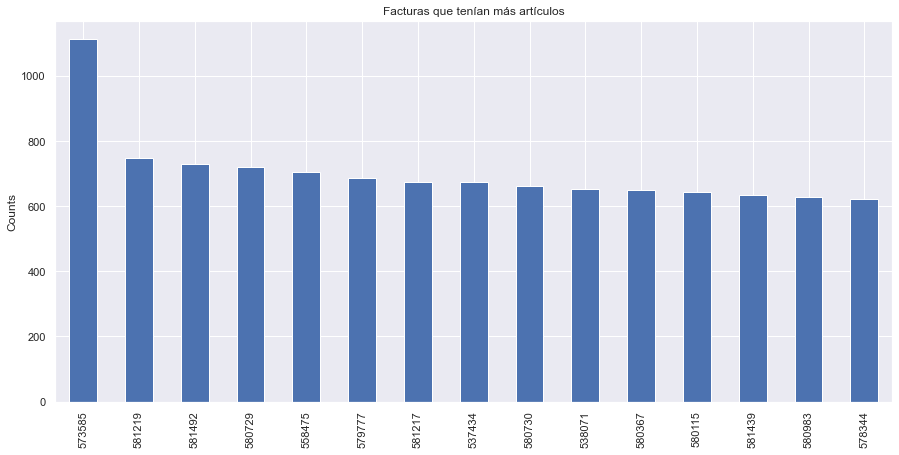

In [21]:
# Plot 'InvoiceNo'
inv_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).head(15).plot.bar(figsize = (15, 7))
plt.ylabel("Counts")
plt.title("Facturas que tenían más artículos");
plt.xticks(rotation=90);

In [22]:
# 'InvoiceNo' que empiezan con 'C' 
df[df['InvoiceNo'].str.startswith('C')].describe()

,Quantity,UnitPrice,CustomerID,Ventas
count,9288.000000,9288.000000,8905.000000,9288.000000
mean,-29.885228,48.393661,14991.667266,-96.556039
std,1145.786965,666.600430,1706.772357,2039.905511
min,-80995.000000,0.010000,12346.000000,-168469.600000
25%,-6.000000,1.450000,13510.000000,-17.700000
50%,-2.000000,2.950000,14895.000000,-8.500000
75%,-1.000000,5.950000,16393.000000,-3.700000
max,-1.000000,38970.000000,18282.000000,-0.120000


Parece que los pedidos (facturas) que comienzan con 'C' son los pedidos de "Cancelación" / "Devolución". Esto explica por qué hay cantidades negativas. Los ignoraremos en la parte de limpieza de datos.

In [23]:
# ‘C’ de pedidos cancelados
cancelado_df = df[df['InvoiceNo'].str.contains('C', na = False)]
cancelado_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Ventas
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96


Las 'InvoiceNo' que comienzan con "C" son pedidos cancelados. Por ello, no se incluyen en los ingresos de la empresa.

### 2.4.2 - 'StockCode'

In [24]:
# 2 - 'StockCode' - Número único para cada artículo comprado 
df['StockCode'].value_counts().head()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: StockCode, dtype: int64

'StockCode'(nominal). Se trata un número integral de 5 dígitos asignado de forma única a cada artículo.

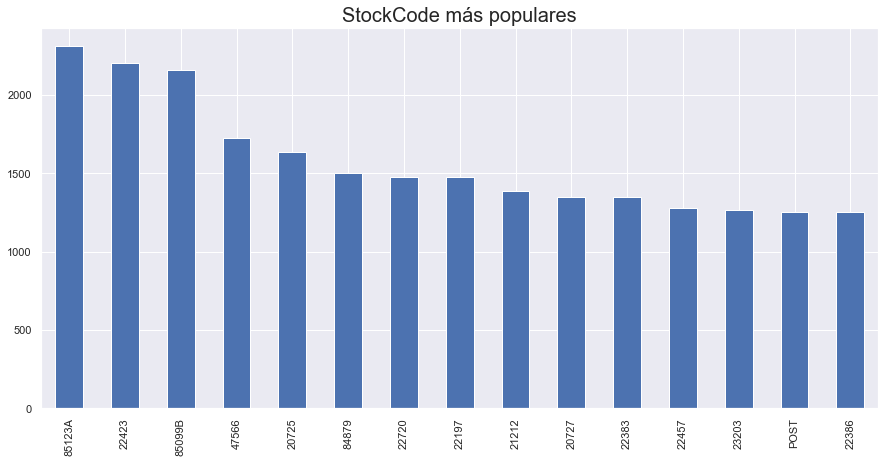

In [25]:
# Plot 'StockCode' en el dataset
df['StockCode'].value_counts().sort_values(ascending=False).head(15).plot.bar(figsize = (15, 7))
plt.title('StockCode más populares', fontsize = 20)
plt.show()

La mayoría de los códigos de 'StockCode' son distintos. Podría significar que la empresa vende productos diferentes y que no existe una fuerte especialización y por ello tampoco un 'StockCode' específico.

Analizamos más en detalle el contenido de la variable 'StockCode', buscando un eventual conjunto de códigos que contendría únicamente letras.

In [26]:
lista_special_codigo = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
lista_special_codigo

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [27]:
for code in lista_special_codigo:
    print("{:<15} -> {:<30}".format(code, df[df['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
DOT             -> DOTCOM POSTAGE                
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
S               -> SAMPLES                       
AMAZONFEE       -> AMAZON FEE                    
DCGS0076        -> SUNJAR LED NIGHT NIGHT LIGHT  
DCGS0003        -> BOXED GLASS ASHTRAY           
gift_0001_40    -> Dotcomgiftshop Gift Voucher £40.00
DCGS0070        -> CAMOUFLAGE DOG COLLAR         
m               -> Manual                        
gift_0001_50    -> Dotcomgiftshop Gift Voucher £50.00
gift_0001_30    -> Dotcomgiftshop Gift Voucher £30.00
gift_0001_20    -> Dotcomgiftshop Gift Voucher £20.00
DCGS0055        -> ARTÍCULO DESCONOCIDO          
DCGS0072        -> ARTÍCULO DESCONOCIDO          
DCGS0074        -> ARTÍCULO DESCONOCIDO          
DCGS0069        -> OOH LA LA DOGS 

Observamos que hay varios tipos de transacciones peculiares, como por ejemplo tasas bancarias ('Bank Charges'). La empresa e-commerce tendría que reorganizar sus códigos especiales para mejorar su eficiencia, ya que a primera vista parece difícil entender la información obtenida.

### 2.4.3 - 'Description'

In [28]:
# 3 - 'Description' - Descripción de los productos
df['Description'].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

'Description' (nominal): descripciones de cada artículo.

Ahora analizamos las descripciones en minúsculas.

In [29]:
# Creamos 'descripciones_minúsculas' para analizarlas
df.loc[df.Description.isnull()==False, "descripciones_minúsculas"] = df.loc[
    df.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

df.descripciones_minúsculas.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    541178
True        731
Name: descripciones_minúsculas, dtype: int64

El objetivo es analizar el contenido de las descripciones en minúsculas.

In [30]:
# Hidden missing valores (mostrar “missing” y “?”) en las descripciones en minúsculas
df[df["descripciones_minúsculas"].str.contains("[?]", na=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Ventas,descripciones_minúsculas
7313,537032,21275,?,-30,12/3/2010 16:50,0.0,NaN,United Kingdom,-0.0,?
21518,538090,20956,?,-723,12/9/2010 14:48,0.0,NaN,United Kingdom,-0.0,?
38261,539494,21479,?,752,12/20/2010 10:36,0.0,NaN,United Kingdom,0.0,?
43662,540100,22837,?,-106,1/4/2011 16:53,0.0,NaN,United Kingdom,-0.0,?
50806,540558,21258,?,-29,1/10/2011 10:04,0.0,NaN,United Kingdom,-0.0,?
...,...,...,...,...,...,...,...,...,...,...
514649,579734,84859C,wet?,-153,11/30/2011 14:25,0.0,NaN,United Kingdom,-0.0,wet?
514735,579742,85204,lost??,-1131,11/30/2011 14:34,0.0,NaN,United Kingdom,-0.0,lost??
524370,580547,21201,???,-390,12/5/2011 9:29,0.0,NaN,United Kingdom,-0.0,???
535324,581201,22217,damages?,-155,12/7/2011 18:30,0.0,NaN,United Kingdom,-0.0,damages?


Los artículos que contienen letras minúsculas parecen corresponder a los pedidos cancelados.


In [31]:
# Eliminamos 'descripciones_minúsculas'
df = df.drop(columns=['descripciones_minúsculas'])

Seguimos con el análisis de 'Description'. Aquí analizamos los artículos comprados con mayor frecuencia.

In [32]:
# Artículos comprados con mayor frecuencia
df['Description'].value_counts().head(10)

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
ARTÍCULO DESCONOCIDO                  1454
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
Name: Description, dtype: int64

Creamos un gráfico para ver cuáles son los 15 productos más vendidos.

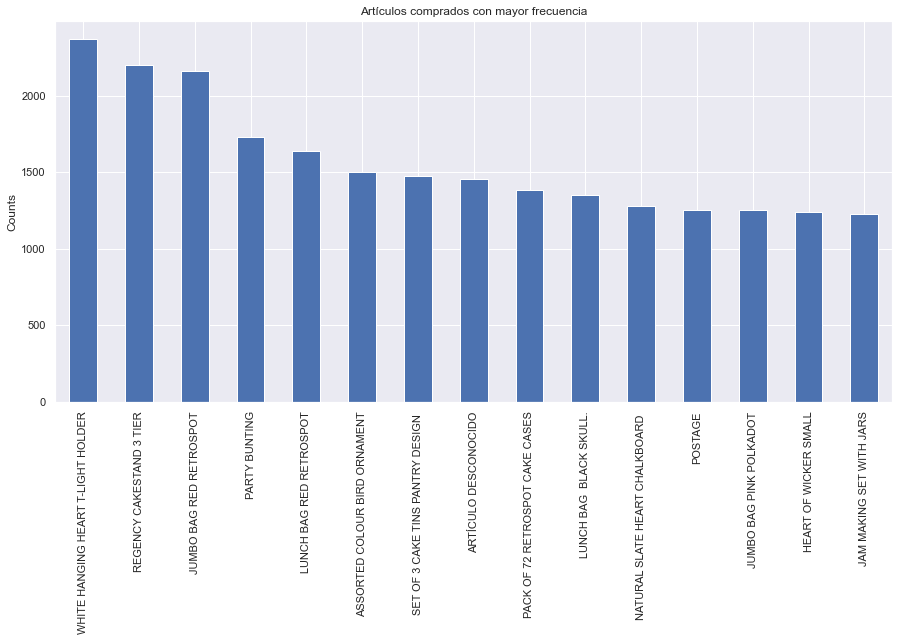

In [33]:
# Plot 15 artículos más vendidos 
df['Description'].value_counts().sort_values(ascending=False).head(15).plot.bar(figsize = (15, 7))
plt.ylabel("Counts")
plt.title("Artículos comprados con mayor frecuencia");
plt.xticks(rotation=90);

'Description' y 'StockCode' están correlacionados (ver el diagrama de 'Description'), lo cual tiene sentido.

In [34]:
# Tail de 'Description'
df['Description'].value_counts().tail()

GLASS BEAD HOOP NECKLACE BLACK        1
thrown away-can't sell.               1
label mix up                          1
SET OF 4 KNICK KNACK TINS  DOILEY     1
PINK CHERRY BLOSSOM CUP & SAUCER      1
Name: Description, dtype: int64

Observamos que los artículos que son conformes suelen estar en mayúsculas y que los productos no válidos o cancelados están en minúsculas.

In [35]:
# Productos en mayúsculas
df[~df['Description'].str.isupper()]['Description'].value_counts().head()

Manual                                572
BAG 125g SWIRLY MARBLES               304
BAG 250g SWIRLY MARBLES               252
3 TRADITIONAl BISCUIT CUTTERS  SET    240
POLYESTER FILLER PAD 40x40cm          193
Name: Description, dtype: int64

Analizando las letras en mayúsculas y minúsculas de 'Description', vemos que hay algunas unidades con letras minúsculas en su nombre y también que los registros en minúsculas son para pedidos cancelados. 

De nuevo, constatamos que se podría mejorar la gestión de los datos de la tienda Online.

### Información sobre las palabras de productos

En esta parte pretendemos obtener una visión general - con word cloud - de las palabras recurrentes.

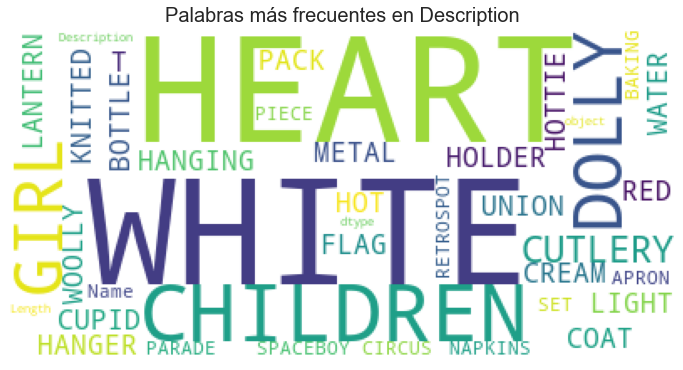

In [36]:
# Wordcloud de 'Description'
from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white').generate(str(df['Description']))

print(wordcloud)
plt.rcParams['figure.figsize'] = (12, 12)
plt.axis('off')
plt.imshow(wordcloud)
plt.title('Palabras más frecuentes en Description', fontsize = 20)
plt.show()

### 2.4.4 - 'Quantity'

In [37]:
# 4 - 'Quantity' - Cantidades de artículos comprados
df['Quantity'].value_counts().head()

1     148227
2      81829
12     61063
6      40868
4      38484
Name: Quantity, dtype: int64

'Quantity' (numérica): cantidades para cada artículo.


In [38]:
df['Quantity'].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

Hemos visto antes que la mayoría de los productos se venden en cantidades de 1 a 10 (% 25-% 75). Al analizar los valores mínimos y máximos de 'Quantity' más en detalle, vemos de nuevo que algunos son atípicos y negativos. **Ignoraremos los valores negativos en la parte limpieza de datos**

In [39]:
# Valores negativos en 'Quantity'
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Ventas
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96


Aquí podemos ver que algunos valores de 'Quantity' parecen ser productos dañados, perdidos o desconocidos.

<AxesSubplot:xlabel='Quantity'>

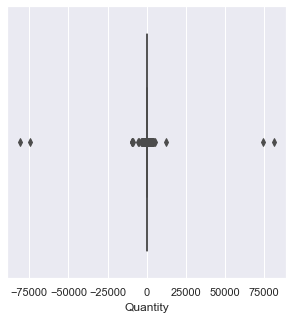

In [40]:
# Outliers en 'Quantity'
fig = plt.figure(figsize=(5, 5))
sns.boxplot(x=df.Quantity)

Destacamos una presencia importante de valores atípicos en 'Quantity'

### 2.4.5 - 'InvoiceDate'

In [41]:
# 4 - 'InvoiceDate' - Fechas en las que se compraron los artículos
df['InvoiceDate'].value_counts().head()

10/31/2011 14:41    1114
12/8/2011 9:28       749
12/9/2011 10:03      731
12/5/2011 17:24      721
6/29/2011 15:58      705
Name: InvoiceDate, dtype: int64

InvoiceDate (numérica): fecha y hora de la factura se trata del día y la hora en que se generó cada transacción.

#### Períodos

Intentamos obtener el período de las transacciones en días.

In [42]:
df["InvoiceDate"] = pd.to_datetime(df.InvoiceDate, cache=True)
df.InvoiceDate.max() - df.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [43]:
print("Datafile comienza el {}".format(df.InvoiceDate.min()))
print("Datafile termina el {}".format(df.InvoiceDate.max()))

Datafile comienza el 2010-12-01 08:26:00
Datafile termina el 2011-12-09 12:50:00


### 2.4.6 - 'UnitPrice'

In [44]:
# 6 - 'UnitPrice' - Precio de un producto único comprado
df['UnitPrice'].value_counts().head(10)

1.25    50496
1.65    38181
0.85    28497
2.95    27768
0.42    24533
4.95    19040
3.75    18600
2.10    17697
2.46    17091
2.08    17005
Name: UnitPrice, dtype: int64

UnitPrice (numerica): Precio unitario. Se trata del precio del producto por unidad en libras esterlinas.

Comprobemos si hay valores negativos en la variable 'UnitPrice'. **En caso de encontrar valores negativos, los ignoraremos en la parte limpieza de datos.**

In [45]:
# Valores negativos de 'UnitPrice'
df[df['UnitPrice'] < 0].describe()

,Quantity,UnitPrice,CustomerID,Ventas
count,2.0,2.00,0.0,2.00
mean,1.0,-11062.06,NaN,-11062.06
std,0.0,0.00,NaN,0.00
min,1.0,-11062.06,NaN,-11062.06
25%,1.0,-11062.06,NaN,-11062.06
50%,1.0,-11062.06,NaN,-11062.06
75%,1.0,-11062.06,NaN,-11062.06
max,1.0,-11062.06,NaN,-11062.06


In [46]:
df[df['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Ventas
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,-11062.06
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,-11062.06


Vemos que hay dos filas para el miso 'UnitPrice'.

<AxesSubplot:xlabel='UnitPrice'>

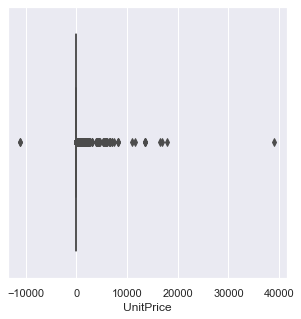

In [47]:
# Outliers de 'UnitPrice'
fig = plt.figure(figsize=(5, 5))
sns.boxplot(x=df.UnitPrice)

In [48]:
# Describe de 'UnitPrice' para tener un contexto estadístico 
df['UnitPrice'].describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

Observamos que casi el 75% de los productos vendidos tienen un precio inferior o igual a 4.13 pounds, por lo cual son baratos. El precio maximo de producto vendido es 38970 pounds. 

### 2.4.7 - 'CustomerID'

In [49]:
# 7 - 'CustomerID' - Identificación única para cada consumidor
df['CustomerID'].value_counts()

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
13391.0       1
16579.0       1
13366.0       1
17763.0       1
17846.0       1
Name: CustomerID, Length: 4372, dtype: int64

CustomerID (nominal): Referencia de cliente. Se trata de un número integral de 5 dígitos asignado a cada cliente.

In [50]:
# CustomerID único
df.CustomerID.nunique()

4372

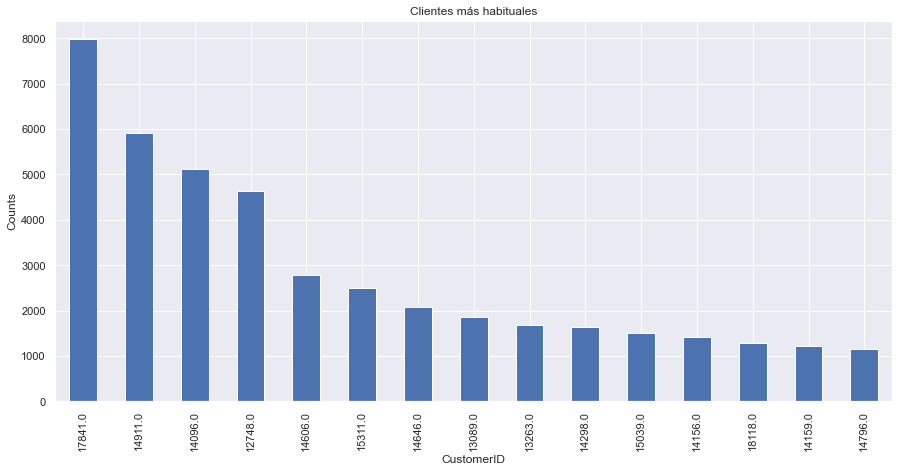

In [51]:
# Plot Top 15 'CustomerID'
df.CustomerID.value_counts().sort_values(ascending=False).head(15).plot.bar(figsize = (15, 7))
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Clientes más habituales")
plt.show();

<AxesSubplot:xlabel='CustomerID'>

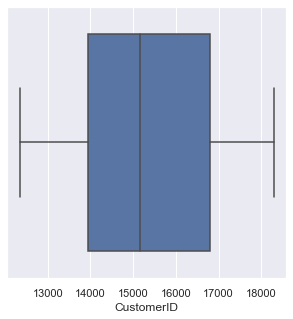

In [52]:
fig = plt.figure(figsize=(5, 5))
sns.boxplot(x=df.CustomerID)

### 2.4.8 - 'Country'

In [53]:
# 8 - 'Country' - Países donde los artículos fueron comprados
df['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

'Country' (nominal): País donde reside cada cliente.

A continuación, obtenemos los países desde los que se registraron los pedidos.

In [54]:
# Número de Países en el dataframe
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Países en el dataframe: {}'.format(len(countries)))


Países en el dataframe: 37


In [55]:
# Número de 'CustomerID' en cada país 
customer_country=df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


Ahora vemos los 15 países con mayor cantidad de productos vendidos.

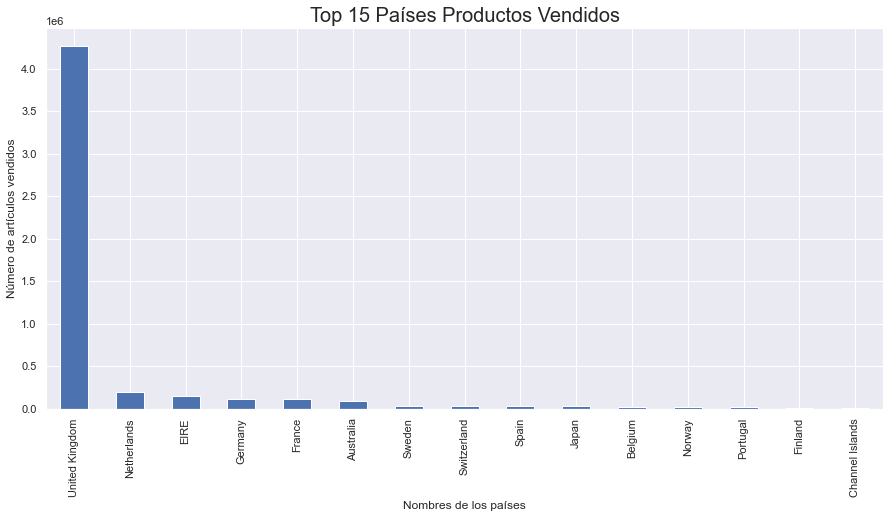

In [56]:
# Top 15 Países según la 'Quantity' vendida Online
df['Quantity'].groupby(df['Country']).agg('sum').sort_values(ascending = False).head(15).plot.bar(figsize = (15, 7))
plt.title('Top 15 Países Productos Vendidos', fontsize = 20)
plt.xlabel('Nombres de los países')
plt.ylabel('Número de artículos vendidos')
plt.show()

In [57]:
# Países que tienen más ventas
hr_paises= df.groupby('Country')['Ventas'].sum().reset_index().sort_values(by= 'Ventas', ascending= False).head(10)
hr_paises

,Country,Ventas
36,United Kingdom,8.187806e+06
24,Netherlands,2.846615e+05
10,EIRE,2.632768e+05
14,Germany,2.216982e+05
13,France,1.974039e+05
0,Australia,1.370773e+05
33,Switzerland,5.638535e+04
31,Spain,5.477458e+04
3,Belgium,4.091096e+04
32,Sweden,3.659591e+04


Los 5 países más importanes son los siguientes:

- Reino Unido
- Los países bajos
- Irlanda (EIRE)
- Alemania
- Francia

A continuación, visualizamos los 15 países con menor cantidad de productos vendidos ('Quantity').

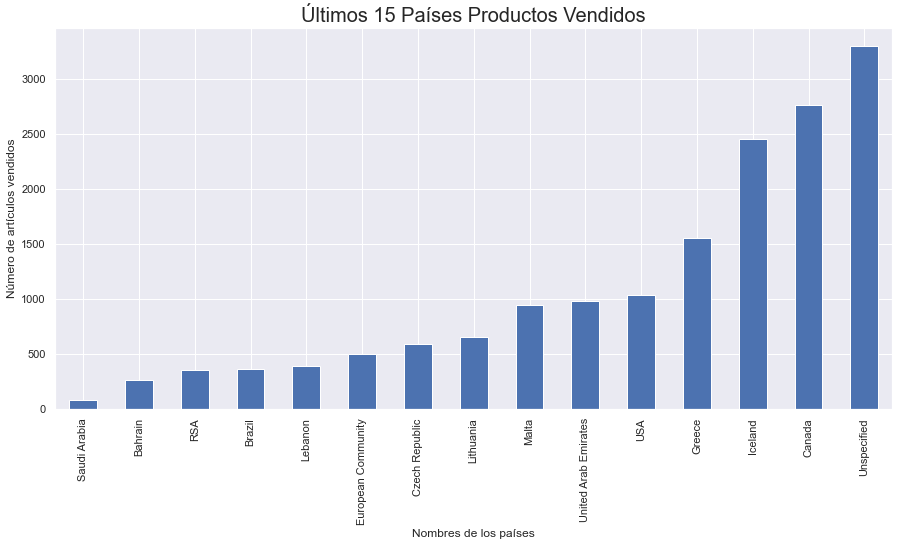

In [58]:
# 15 últimos países según la 'Quantity' vendida Online
df['Quantity'].groupby(df['Country']).agg('sum').sort_values(ascending = True).head(15).plot.bar(figsize = (15, 7))
plt.title('Últimos 15 Países Productos Vendidos', fontsize = 20)
plt.xlabel('Nombres de los países')
plt.ylabel('Número de artículos vendidos')
plt.show()

In [59]:
# Porcentaje de ventas en el Reino Unido (UK)
df.loc[df.Country=="United Kingdom"].shape[0] / df.shape[0] * 100

91.43195628786383

Con los gráficos y el cálculo anterior, vemos que la gran mayoría de productos se vendieron en el Reino Unido (UK):

- 91.43% ventas en el Reino Unido
- solo 8,57% en el extranjero

Podemos decir que nuestro conjunto de datos está muy sesgado hacia el Reino Unido (UK).

## 2.5 - Consumidores y productos

In [60]:
# Número de consumidores y productos 
pd.DataFrame([{'productos': len(df['StockCode'].value_counts()),    
               'transacciones': len(df['InvoiceNo'].value_counts()),
               'consumidores': len(df['CustomerID'].value_counts()),  
              }], columns = ['productos', 'transacciones', 'consumidores'], index = ['cantidad'])

,productos,transacciones,consumidores
cantidad,4070,25900,4372


Constatamos que los datos corresponden a 4372 consumidores, que compraron 4070 productos diferentes. El número total de transacciones realizadas es 25900.

Ahora analizamos la cantidad de productos comprados en cada transacción:

In [61]:
# Cantidad de productos comprados en cada transacción
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Cantidad de productos'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Cantidad de productos
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


Observamos lo siguiente:

- la existencia de pedidos con el prefijo C en la variable **InvoiceNo** indica transacciones que han sido canceladas
- la existencia de clientes que solo compraron una sola vez y un solo producto (nº12346)
- la existencia de clientes que compran varias veces y una gran cantidad de artículos para cada pedido

### 2.5.1 - Pedidos cancelados 

Hemos creado una variable para analizae los pedidos cancelados. **Todos los pedidos cancelados contienen cantidades negativas (ya que es una anulación) y, por lo tanto, tendremos que eliminarlos en la parte limpieza de datos, como hemos indicado anteriormente.**

En primer lugar, vamos a contar el número de transacciones correspondientes a los pedidos cancelados.

In [62]:
# Número de transacciones correspondientes pedidos cancelados
nb_products_per_basket['pedido_cancelado'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['pedido_cancelado'].sum()
n2 = nb_products_per_basket.shape[0]
print('Cantidad de pedidos cancelados: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Cantidad de productos,pedido_cancelado
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Cantidad de pedidos cancelados: 3654/22190 (16.47%) 


Observamos que el número de cancelaciones es importante: 16.47%

Seguidamente, vemos las primeras líneas del dataframe.

In [63]:
# primeras líneas 'CustomerID' 
display(df.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Ventas
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.6
286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-08-02 08:48:00,2.25,12347.0,Iceland,13.5
72263,542237,47559B,TEA TIME OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,12.5
72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,12.5


Cuando se cancela un pedido, tenemos otras transacciones que aparecen, en su mayoría idénticas, excepto por las variables **Cantidad** y **Fecha de factura**.

### 2.5.2  - Análisis de ventas mensuales

Después de haber convertido la columna llamada 'InvoiceDate' al formato de fecha y hora, creamos nuevas columnas en formato de año, mes y día.

In [64]:
# Añadimos nuevas columnas en formato año, mes y día
df['Year_Month']= pd.to_datetime(df['InvoiceDate']).dt.to_period('M')
df['Year']= pd.DatetimeIndex(df['InvoiceDate']).year
df['Month']= pd.DatetimeIndex(df['InvoiceDate']).month
df['Date']= pd.DatetimeIndex(df['InvoiceDate']).day
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Ventas,Year_Month,Year,Month,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,2010,12,1


In [65]:
# Ventas por año
rev_month= df.groupby(['Month', 'Year'])['Ventas'].sum().sort_values(ascending= False).reset_index()
rev_month

,Month,Year,Ventas
0,11,2011,1461756.250
1,10,2011,1070704.670
2,9,2011,1019687.622
3,12,2010,748957.020
4,5,2011,723333.510
5,6,2011,691123.120
6,3,2011,683267.080
7,8,2011,682680.510
8,7,2011,681300.111
9,1,2011,560000.260


Text(0, 0.5, 'Ingresos')

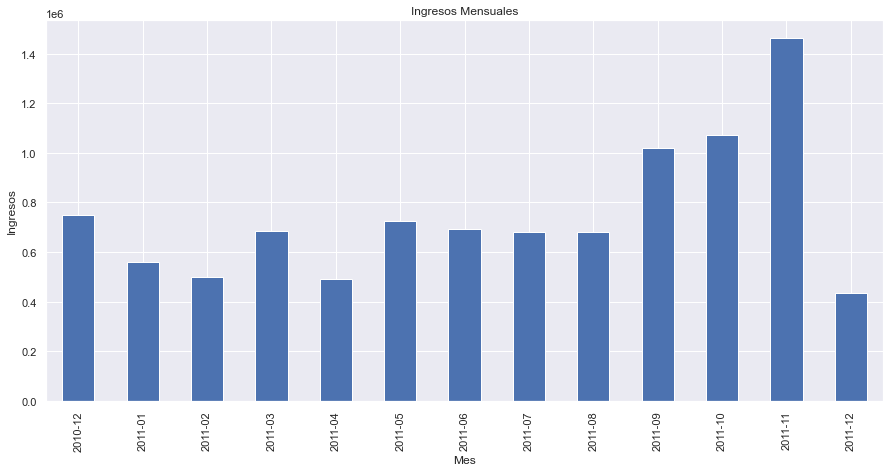

In [66]:
# Ventas por mes año 2011
df.groupby('Year_Month')['Ventas'].sum().plot.bar(figsize = (15, 7))
plt.title("Ingresos Mensuales")
plt.xlabel("Mes")
plt.ylabel("Ingresos")

Tras observar los datos, podemos concluir que la empresa recibe el mayor número de pedidos en noviembre de 2011, ya que no tenemos el mes completo de datos de diciembre de 2011.

### 2.5.3  -  Análisis de ventas semanales

In [67]:
# Copiamos
df1 = df.copy()

Hacemos el analísis de ventas semanales con otro metódo para obtener un heatmap. Creamos nuevas features extrayendo mes y día de 'InvoiceDate'.

In [68]:
# Formatting Date/Time
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], format = '%m/%d/%Y %H:%M')

In [69]:
# Strings
df1['Description'] = df1['Description'].str.replace('.','').str.upper().str.strip()
df1['Description'] = df1['Description'].replace('\s+',' ',regex = True)
df1['InvoiceNo'] = df1['InvoiceNo'].astype(str).str.upper()
df1['StockCode'] = df1['StockCode'].str.upper()
df1['Country'] = df1['Country'].str.upper()

In [70]:
# Añadimos Features
df1['FinalPrice'] = df1['Quantity']*df1['UnitPrice']
df1['InvoiceMonth'] = df1['InvoiceDate'].apply(lambda x: x.strftime('%B'))
df1['Day of week'] = df1['InvoiceDate'].dt.day_name()

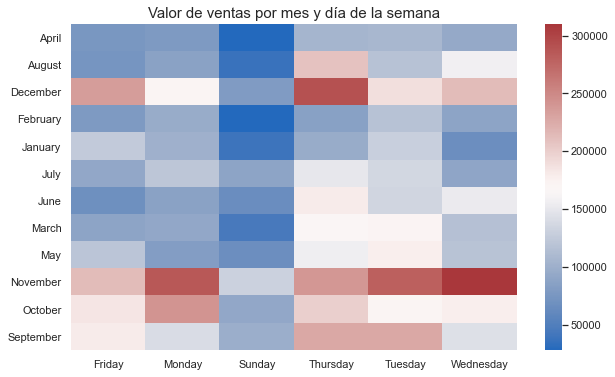

In [71]:
# Obtenemos heatmap
HM_Data = df1.pivot_table(index = 'InvoiceMonth',columns = 'Day of week', values = 'FinalPrice', aggfunc='sum')
plt.figure(figsize = (10,6))
sns.heatmap(HM_Data, cmap = 'vlag').set(xlabel='', ylabel='')
plt.title('Valor de ventas por mes y día de la semana', fontsize = 15)
plt.show()

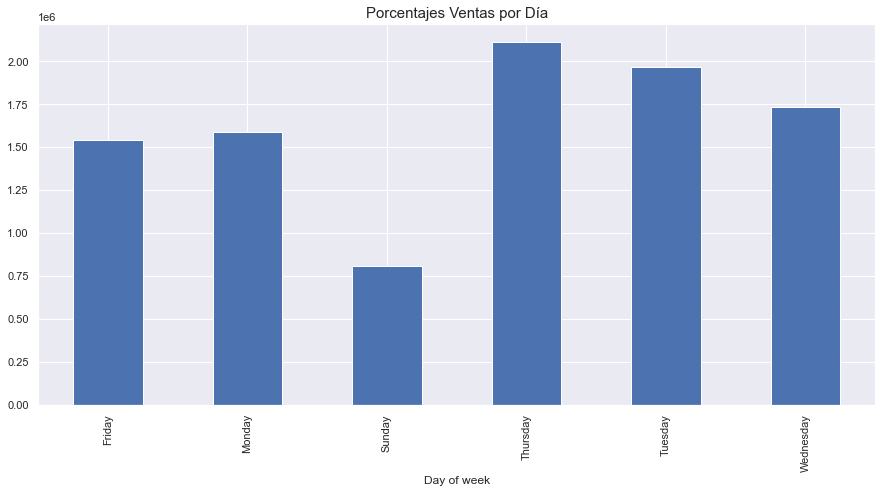

In [72]:
# Plot porcentajes ventas por día 
df1.groupby('Day of week')['FinalPrice'].sum().plot.bar(figsize = (15, 7))
plt.title('Porcentajes Ventas por Día', fontsize = 15)
plt.show()

Sorprendentemente, no hay transacciones los sábados durante todo el período (1 de diciembre de 2010 a 9 de diciembre de 2011). También detectamos que el número de pedidos recibidos por la empresa tiende a aumentar de lunes a jueves y a disminuir posteriormente. El jueves es el día en el que más transacciones se realizan y el domingo en el que menos.

### 2.5.4 - Productos más vendidos

Ahora vemos las transacciones de los 5 artículos más vendidos.

#### 5 productos más vendidos:

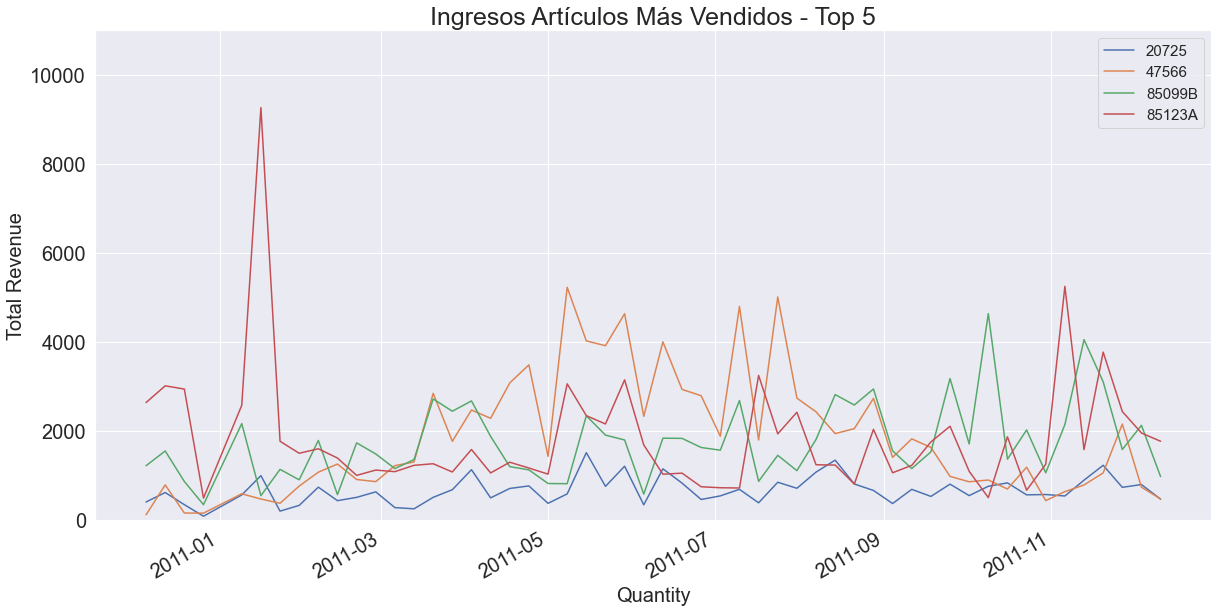

In [73]:
# 5 artículos más vendidos
import pylab as plot
df3d = df[df["StockCode"].isin(["85123A","224233","85099B","47566","20725"])]
df3d=df3d.groupby([pd.Grouper(key='InvoiceDate', freq='W'),"StockCode"])['Ventas'].sum().reset_index().sort_values('InvoiceDate')
df3d.pivot(index="InvoiceDate", columns="StockCode", values="Ventas").plot(figsize=(20, 10),fontsize=10)
plt.ylim(0, 11000)
plt.ylabel('Total Revenue',fontsize=20)
plt.xlabel("Quantity",fontsize=20)
plt.title("Ingresos Artículos Más Vendidos - Top 5",fontsize=25)
plot.tick_params(axis='both', which='major', labelsize=20)
plot.legend(loc=1, prop={'size': 15})
plt.show()

Hemos observado a lo largo del EDA que:

- El país con la mayor cantidad de pedidos es el Reino Unido (UK).
- El número de compras tiende a aumentar durante la temporada navideña.
- No existe una correlación clara entre los días del mes y el número de compras realizadas.
- Sorprendentemente,  no se realizan compras los sábados y observamos que las ventas parecen menores los fines de semana.

# 3 - Limpieza de datos

#### Creamos de nuevo la variable 'Ventas'

In [74]:
# Nueva feature 'Ventas' 
df_limp['Ventas'] = df_limp['Quantity'] * df_limp['UnitPrice']

## 3.1 - Eliminar valores nulos

Tenemos valores NULL en 'CustomerID'. Eliminamos las filas que contienen valores nulos.

In [75]:
# Eliminamos los valores nulos
df_limp.dropna(subset=['CustomerID'], inplace=True)

## 3.2 -  Eliminar valores negativos

‘Quantity’ tiene valores negativos, que pueden ser el resultado de devolución de productos o de pedidos cancelados. Ignoremos las filas con cantidad negativa.

In [76]:
# Tratar los valores negativos de 'Quantity'
df_limp = df_limp.loc[df_limp['Quantity'] > 0]

‘UnitPrice’ también tiene valores negativos. Las ignoramos.

In [77]:
# Tratar los valores negativos de 'UnitPrice'
df_limp = df_limp.loc[df_limp['UnitPrice'] > 0]

## 3.3 - Detectar y eliminar los valores atípicos

Comprobamos si hay valores atípicos en las distribuciones de 'Ventas' y en ese caso los eliminamos.

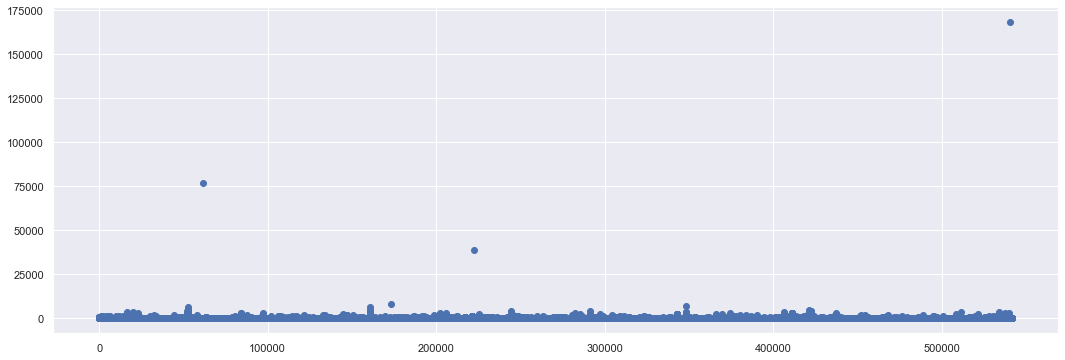

In [78]:
# Detectamos los outliers de 'Ventas'
plt.figure(figsize=(18,6))
plt.scatter(x=df_limp.index, y=df_limp['Ventas'])

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.,  600000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

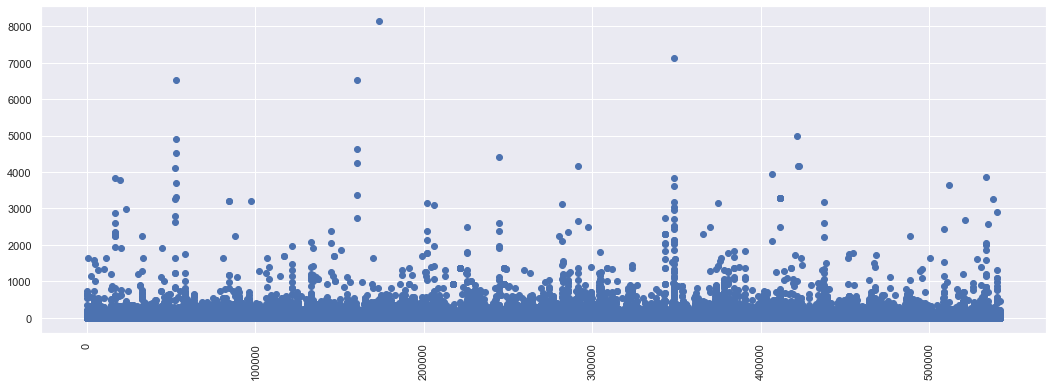

In [79]:
# Eliminamos los outliers
df_limp = df_limp[df_limp['Ventas'] < 25000]
plt.figure(figsize=(18,6))
plt.scatter(x=df_limp.index, y=df_limp['Ventas'])
plt.xticks(rotation=90)

In [80]:
# Copiamos los datos limpios hasta ahora para el análisis RFM
df_RFM = df_limp.copy()

## 3.4 - 'Cast' datetime

Convertimos los datos al tipo fecha y hora de Python.

In [81]:
# Casting a datetime
df_limp['InvoiceDate'] = pd.to_datetime(df_limp['InvoiceDate'])
df_limp = df_limp.set_index('InvoiceDate')

## 3.5 - Comprobamos la limpieza de los datos

In [82]:
# Info datos limpios
df_limp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397881 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397881 non-null  object 
 1   StockCode    397881 non-null  object 
 2   Description  397881 non-null  object 
 3   Quantity     397881 non-null  int64  
 4   UnitPrice    397881 non-null  float64
 5   CustomerID   397881 non-null  float64
 6   Country      397881 non-null  object 
 7   Ventas       397881 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 27.3+ MB


Después de la limpieza de datos, tenemos 397,881 filas y 8 columnas.

In [83]:
# Null values
df_limp.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
Country        0
Ventas         0
dtype: int64

A continuación vemos los valores únicos para cada columna.

In [84]:
# Valores únicos
def unique_counts(df_limp):
   for i in df_limp.columns:
       count = df_limp[i].nunique()
       print(i, ": ", count)
unique_counts(df_limp)

InvoiceNo :  18529
StockCode :  3664
Description :  3876
Quantity :  299
UnitPrice :  440
CustomerID :  4337
Country :  37
Ventas :  2936


# 4 - Series temporales

In [85]:
# Librerías para las series temporales
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import pylab
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *

## 4.1 - Analizar las ventas

In [86]:
# Tiempo
df_ts = df_limp.copy()[['Ventas']]
df_ts.head()

,Ventas
InvoiceDate,
2010-12-01 08:26:00,15.30
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,22.00
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,20.34


Observamos que cada 'InvoiceDate' tiene una hora y fecha precisa (basada en el día y la hora en la que se realizó el pedido).

<AxesSubplot:xlabel='InvoiceDate'>

<Figure size 720x432 with 0 Axes>

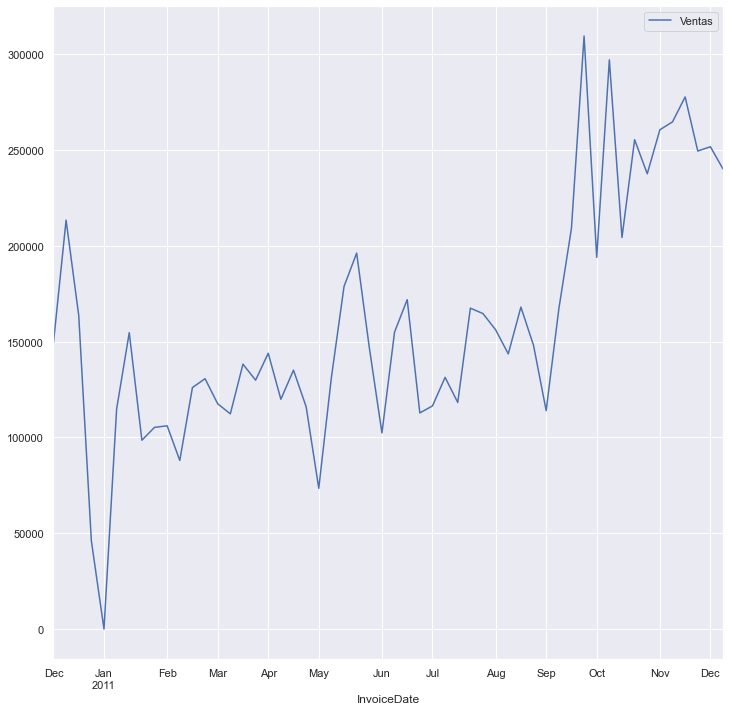

In [87]:
# Analizamos la distribución de las venta en el tiempo
plt.figure(figsize=(10,6))
df_resample = df_ts.resample('W').sum()
df_resample.plot()

Con un scatter plot de las ventas, observamos la distribución a lo largo del año. Constatamos que las ventas alcanzan su máximo en noviembre hasta diciembre. Posteriormente hay una disminución hasta enero. Además, la semana que tiene 0 ventas en enero parece sospechosa. La analizamos a continuación.

In [88]:
# Analizamos week 0
df_resample['12-2010':'01-2011']

,Ventas
InvoiceDate,
2010-12-05,149386.33
2010-12-12,213447.72
2010-12-19,163770.73
2010-12-26,46109.11
2011-01-02,0.00
2011-01-09,114865.27
2011-01-16,154714.94
2011-01-23,98574.38
2011-01-30,105288.77


Durante el período de vacaciones de año nuevo, la tienda estuvo probablemente cerrada y no procesaba pedidos. Suponemos que por eso no registraron ninguna venta.

## 4.2 - Ventas por países

Ahora usamos los datos originales - sin limpieza - ya que queremos visualizar los pedidos cancelados.

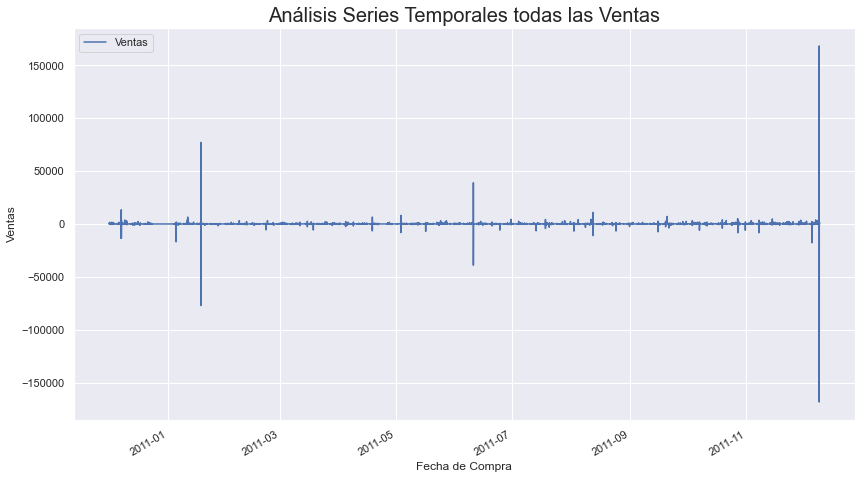

In [89]:
# Time Series plot para todos los países
plt.rcParams['figure.figsize'] = (14, 8)
df.plot(x = 'InvoiceDate', y = 'Ventas')
plt.title("Análisis Series Temporales todas las Ventas", fontsize = 20)
plt.xlabel('Fecha de Compra')
plt.ylabel('Ventas')
plt.show()

Text(0.5, 1.0, 'Series Temporales UK')

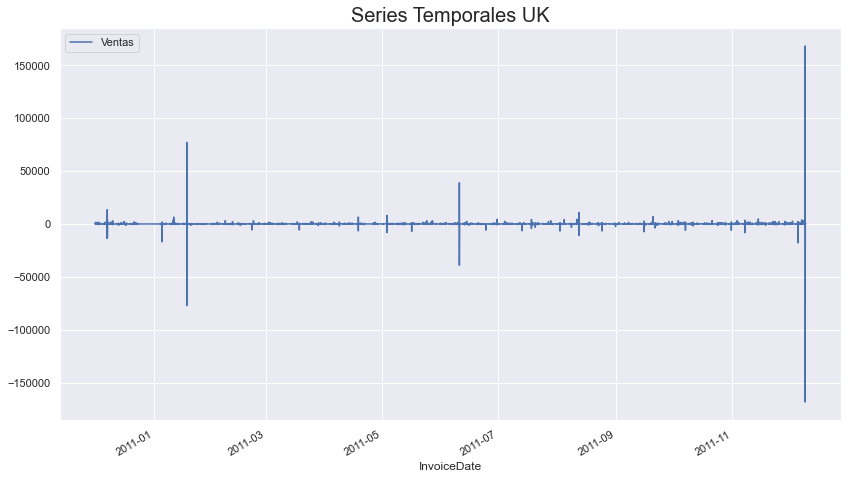

In [90]:
# Función plot time-series plot para cualcuier país 
def time_series(country):
  dataset = df[df['Country'] == country]
  dataset.plot(x = 'InvoiceDate', y = 'Ventas')

# Plot time-series para el Reino Unido (UK) 
time_series('United Kingdom')
plt.title('Series Temporales UK', fontsize = 20)

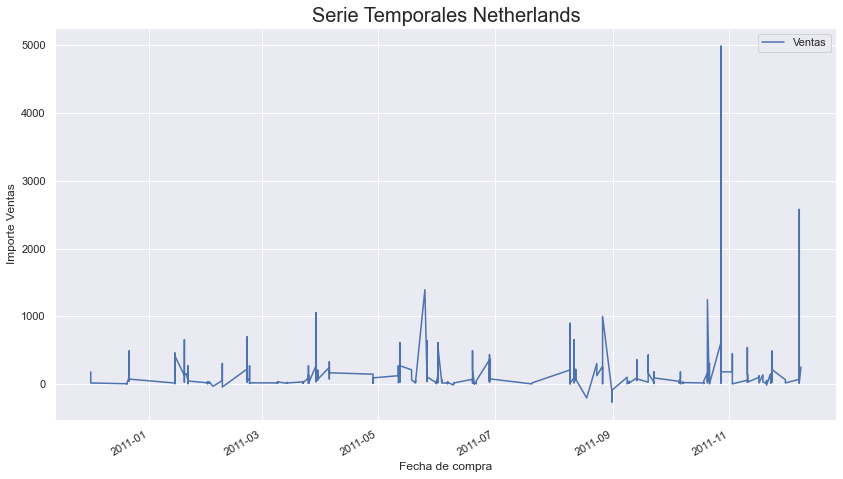

In [91]:
# Time-series plot para Netherlands
dataset = df[df['Country'] == 'Netherlands']
dataset.plot(x = 'InvoiceDate', y = 'Ventas')
plt.title('Serie Temporales Netherlands', fontsize = 20)
plt.xlabel('Fecha de compra')
plt.ylabel('Importe Ventas')
plt.show()

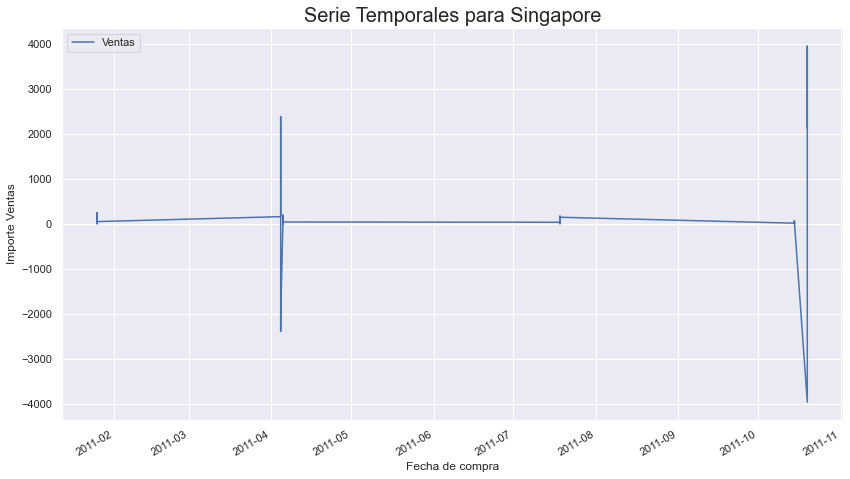

In [92]:
# Time-series plot para Singapore
dataset = df[df['Country'] == 'Singapore']
dataset.plot(x = 'InvoiceDate', y = 'Ventas')
plt.title('Serie Temporales para Singapore', fontsize = 20)
plt.xlabel('Fecha de compra')
plt.ylabel('Importe Ventas')
plt.show()

Analizando los gráficos de serie temporales, observamos que las tendencias para el Reino Unido, comparado con el resto de países, varían más en términos de cantidad.

- Esto puede ser debido a que, dado que la tienda está ubicada en el Reino Unido, los consumidores piden cantidades más pequeñas. 
- Mientras que el resto de países realizan pedidos de más cantidades, por lo cual, pueden ser pedidos que provienen de mayoristas. 

## 4.3 - Ventas y su distribución en el tiempo

In [93]:
# Agrupamos 'InvoiceDate' y 'Ventas' para un análisis series temporales adicional
ventas = df_limp.copy().groupby('InvoiceDate')['Ventas'].sum()
ventas.index = pd.to_datetime(ventas.index)

In [94]:
# Función para time series plots usando los datos limpios
def plotVentas(ventas,time_freq,xtick,freq):
    trend = ventas.resample(time_freq).sum()
    holidays = ['2010-12-27', '2010-12-28', '2011-01-03', '2011-04-22', '2011-04-25', '2011-04-29', '2011-05-02',
            '2011-05-30', '2011-08-29']

    fig = plt.figure(figsize=(20, 5))

    plt.plot(trend)

    dates = trend.index[::xtick]
    labels = dates.strftime('%b %d %H:%M %A')
    
    if time_freq!='H':
        [pylab.axvline(_x, linewidth=1, color='r',ls='--') for _x in holidays]
        labels = dates.strftime('%b %d')

    plt.xticks(dates, labels, rotation=90)
    plt.legend(['TotalPrecio','UK Vacaciones'])
    plt.title(freq+' ventas desde Dec-1-2010 hasta Dec-09-2011')
    plt.show()

A continuación, intentamos obtener información con las series temporales con los datos limpios. Además, hemos añadido el periodo de las vacaciones en el Reino Unido para ver si obtenemos correlaciones.

#### Ventas diarias

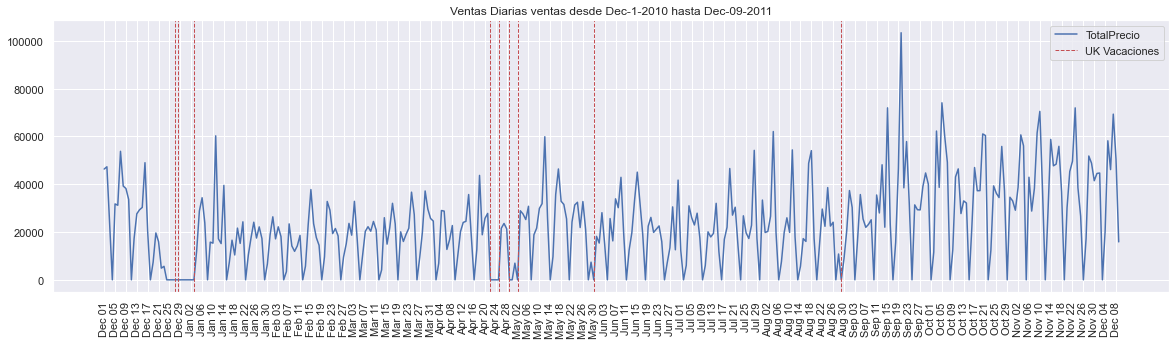

In [95]:
plotVentas(ventas,'D',4,'Ventas Diarias')

####  Ventas por hora

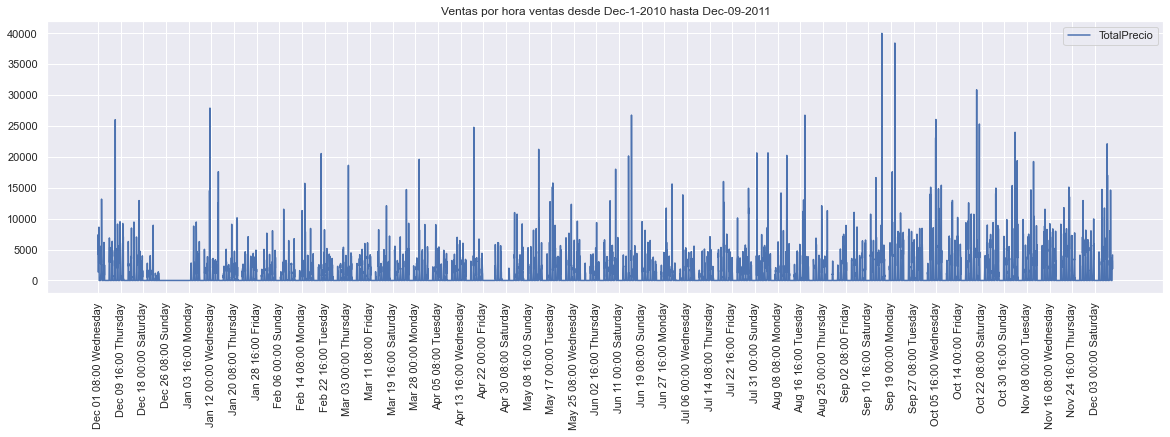

In [96]:
plotVentas(ventas,'H',200,'Ventas por hora')

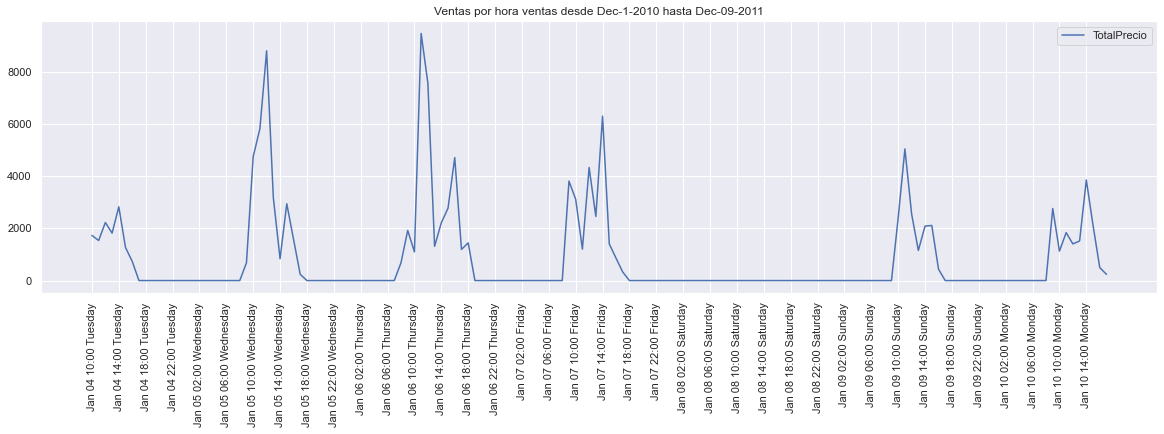

In [97]:
plotVentas(ventas['2011-01-01':'2011-01-10'],'H',4,'Ventas por hora')

#### Ventas semanales

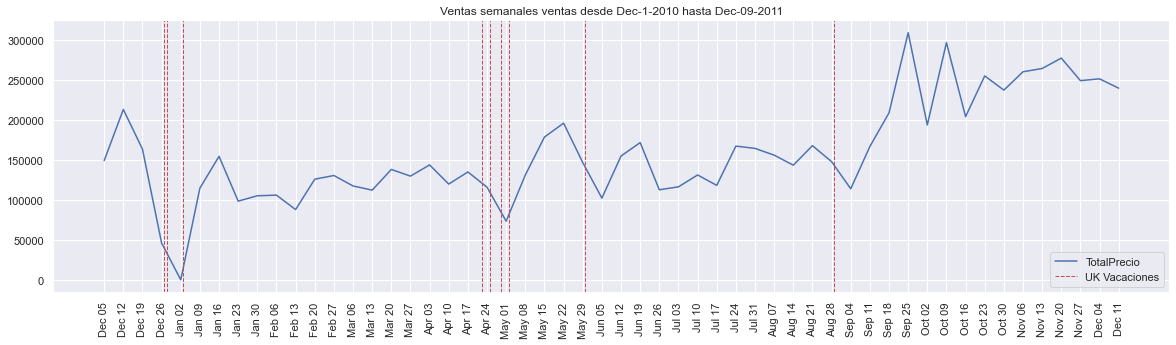

In [98]:
plotVentas(ventas,'W',1,'Ventas semanales')

#### Ventas mensuales

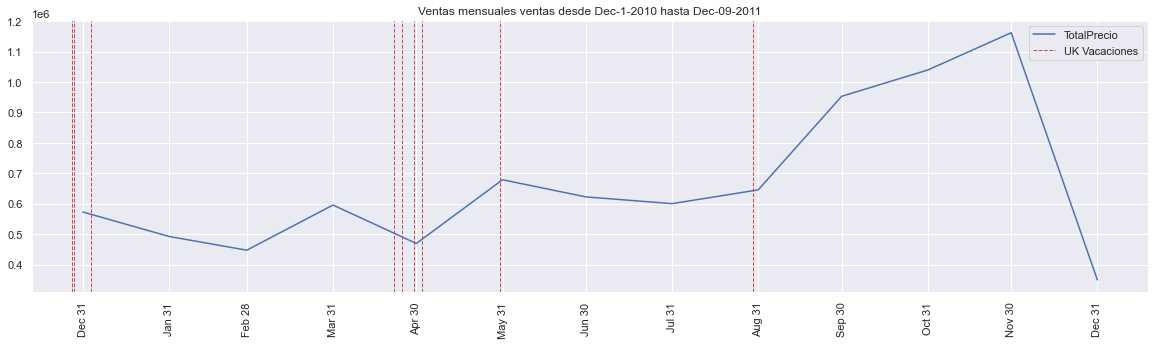

In [99]:
plotVentas(ventas,'M',1,'Ventas mensuales')

#### Observaciones:

1. De nuevo, observamos que no hay ventas durante los sábados.
1. Las ventas caen durante las vacaciones.
1. No hay ventas durante el Boxing Day (26 de diciembre), lo que probablemente significa que la empresa no ofrece promociones durante las vacaciones / días especiales.
1. Las ventas se realizan solo durante el horario laboral, entre las 8:00 a.m y las 6:00 p.m.
1. De nuevo, no se observa una tendencia particular en las ventas mensuales y semanales. En general, existe una tendencia de aumento de ventas a lo largo del mes y para cada uno de los meses.

# 5 - Análisis RFM

El análisis **RFM** (actualidad, frecuencia, monetario) es una técnica de segmentación de clientes que utiliza el comportamiento de compra para clasificar a los clientes en grupos. Asimismo, RFM ayuda a clasificar los clientes en varias categorías o grupos para identificar los clientes que tienen más probabilidades de responder a las promociones y también para futuros servicios personalizados. 

- RECENCY (R): Días desde la última compra
- FRECUENCIA (F): Número total de compras
- VALOR MONETARIO (M): Dinero total que gastó este cliente.

Por tanto, vamos a crear esos 3 atributos (RFM) para cada cliente.

### Datos incompletos

Añadimos esta restricción para el análisis RFM

In [100]:
df_RFM = df_RFM.loc[df_RFM['InvoiceDate'] < '2011-12-01']

## 5.1 - Recencia - ¿Cuánto de reciente fue la última compra del cliente?

Para calcular la 'Recency', debemos elegir una fecha de referencia a partir del cual determinamos cuántos días atrás fue la última compra del cliente.

In [101]:
# Fecha de referencia
df_RFM['InvoiceDate'].max()

'2/9/2011 9:10'

In [102]:
df_rfmseg = df_RFM

In [103]:
# Guardar última fecha en nuestro conjunto de datos 
import datetime as dt
latest_date = dt.date(2011,12,9)

In [104]:
df_rfmseg['fecha'] = pd.DatetimeIndex(df_rfmseg.InvoiceDate).date

In [105]:
# Agrupamos por 'CustomerID' y Fecha de última compra
recency_df = df_rfmseg.groupby(['CustomerID'],as_index=False)['fecha'].max()
recency_df.columns = ['CustomerID','UltimaFechaCompra']
recency_df.head()

,CustomerID,UltimaFechaCompra
0,12347.0,2011-12-07
1,12348.0,2011-01-25
2,12349.0,2011-11-21
3,12350.0,2011-02-02
4,12352.0,2011-11-03


#### Calculamos la frecuencia teniendo en cuenta cuantas veces ha comprado el cliente , con referencia a la última fecha, en días.

Como hemos visto antes, la última fecha que tenemos es: 2011-12-09. La usaremos como referencia.


In [106]:
# Última fecha como referencia
recency_df['Recency'] = recency_df.UltimaFechaCompra.apply(lambda x : (latest_date - x).days)
recency_df.head()

,CustomerID,UltimaFechaCompra,Recency
0,12347.0,2011-12-07,2
1,12348.0,2011-01-25,318
2,12349.0,2011-11-21,18
3,12350.0,2011-02-02,310
4,12352.0,2011-11-03,36


## 5.2 - Frecuencia  – ¿Cuántas veces compró un cliente?

La frecuencia nos ayuda a saber cuántas veces compró un cliente. Para hacer eso, debemos comprobar **cuántos pedidos registra el mismo cliente**.

In [107]:
# Cuántas veces compró el consumidor
frequency_df = df_rfmseg.copy()
frequency_df= df_rfmseg.groupby('CustomerID',as_index=False).agg({'InvoiceNo': lambda num: len(num)})
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12347.0,118
1,12348.0,23
2,12349.0,73
3,12350.0,17
4,12352.0,30


## 5.3 - Monetario - ¿Cuánto gastan?

El atributo monetario responde a la pregunta: **¿Cuánto dinero se gastó el cliente a lo largo del tiempo?** Para calcularlo, tenemos que crear una nueva columna de coste total.

#### Calculamos el coste total.


In [108]:
# Calculamos el coste total - como lo hicimos antes 
df_rfmseg['Coste_Total'] = df_rfmseg['UnitPrice'] * df_rfmseg['Quantity']

In [109]:
# Total compras por un consumidor con respeto a la útlima fecha de compra
monetary_df=df_rfmseg.groupby('CustomerID',as_index=False)['Coste_Total'].sum()
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12347.0,2706.32
1,12348.0,1120.24
2,12349.0,1757.55
3,12350.0,334.40
4,12352.0,608.23


In [110]:
# Eliminamos 'LastPurchaseDate'
recency_df.drop(columns=['UltimaFechaCompra'],inplace=True)

## 5.4 - Tabla RFM

Primero combinamos actualidad, frecuencia y monetario.

In [111]:
# Combinamos dataframes (recency, frquency, monetary) 
rfm = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')
rfm = rfm.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')
rfm.set_index('CustomerID',inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,118,2706.32
12348.0,318,23,1120.24
12349.0,18,73,1757.55
12350.0,310,17,334.40
12352.0,36,30,608.23


Observación:

- CustomerID 12747 tiene frecuencia: 118, valor monetario: 2706.32 y antigüedad: 2 días

A continuación, revisamos los detalles del primer cliente con los datos sin limpieza:

In [112]:
# Detalles del primer cliente, usando el primer df sin limpieza
primer_consumidor = df[df['CustomerID']==12346.0]
primer_consumidor

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Ventas,Year_Month,Year,Month,Date
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,2011-01,2011,1,18
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.6,2011-01,2011,1,18


El primer cliente ha comprado solo una vez. Compró un producto en una gran cantidad (74,215). El precio unitario es muy bajo. Quizás se trata de una venta de liquidación.

#### Dividimos las métricas

La forma más sencilla de dividir las métricas en segmentos es mediante el uso de cuartiles, ya que nos da un punto de partida para el análisis detallado.

Ahora creamos segmentos de clientes a partir del modelo RFM al utilizar **Cuartiles**. Asignamos una puntuación de 1 a 4 a Actualidad, Frecuencia y Monetaria. 4 es el valor mejor / más alto y 1 es el valor peor / más bajo. Una puntuación RFM final se calcula simplemente combinando números de puntuación RFM individuales.

In [113]:
# Agrupamos valores por cuartiles 
rfm['r_quartile'] = pd.qcut(rfm['Recency'], 4, ['4','3','2','1'])
rfm['f_quartile'] = pd.qcut(rfm['Frequency'], 4, ['1','2','3','4'])
rfm['m_quartile'] = pd.qcut(rfm['Monetary'], 4, ['1','2','3','4'])

rfm['r_quartile'] = rfm['r_quartile'].astype(int)
rfm['f_quartile'] = rfm['f_quartile'].astype(int)
rfm['m_quartile'] = rfm['m_quartile'].astype(int)

rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12347.0,2,118,2706.32,4,4,4
12348.0,318,23,1120.24,1,2,4
12349.0,18,73,1757.55,3,4,4
12350.0,310,17,334.40,1,2,2
12352.0,36,30,608.23,2,2,3


Obtenemos informaciones interesantes, así como los sesgados presentes en nuestros datos. Lo importante, es tener en cuenta que agruparemos estos valores en cuartiles.

Ahora sumamos la puntuación:

In [114]:
# Sumar puntuación
rfm['RFM_Score'] = rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
rfm['RFM_Score'].head()

CustomerID
12347.0    12
12348.0     7
12349.0    11
12350.0     5
12352.0     7
Name: RFM_Score, dtype: int64

#### 10 de los mejores consumidores

In [115]:
# Mejores consumidores
rfm['RFM_Score'].sort_values(ascending=False).head(10)

CustomerID
12347.0    12
14060.0    12
14132.0    12
14125.0    12
14121.0    12
14102.0    12
14096.0    12
17346.0    12
17350.0    12
14092.0    12
Name: RFM_Score, dtype: int64

#### 5 de los mejores consumidores

In [116]:
# Mejores consumidores
best = rfm[rfm['RFM_Score']== 12]
best.head(5)

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12347.0,2,118,2706.32,4,4,4,12
12362.0,3,148,3127.99,4,4,4,12
12417.0,3,71,1447.36,4,4,4,12
12433.0,0,339,10767.76,4,4,4,12
12437.0,1,125,2900.36,4,4,4,12


## 5.5 - Segmentamos los clientes con RFM

Definimos los RFM levels para cada puntuación:

In [117]:
# Función para definir RFM levels para cada rango de puntuación
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Best'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Campeón'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Leal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potencial'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Prometedor'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Necesita Atención'
    else:
        return 'Requiere Activación'

In [118]:
# Creamos una nueva variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Level
CustomerID,,,,,,,,
12347.0,2,118,2706.32,4,4,4,12,Best
12348.0,318,23,1120.24,1,2,4,7,Leal
12349.0,18,73,1757.55,3,4,4,11,Best
12350.0,310,17,334.40,1,2,2,5,Prometedor
12352.0,36,30,608.23,2,2,3,7,Leal


Finalmente, podemos agrupar a nuestros clientes por su nivel de RFM. Así calculamos los valores promedio para cada RFM_Level, lo que nos devuelve un tamaño de cada segmento.

In [119]:
# Calcular valores promedio para cada RFM_Level
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

In [120]:
rfm_level_agg

Recency Frequency Monetary      
                       mean      mean     mean count
RFM_Level                                           
Best                   19.6     123.6   2648.9  1222
Campeón                62.2      46.5    716.0   352
Leal                   87.6      31.6    537.8   360
Necesita Atención     165.8      10.6    199.4   269
Potencial              90.6      22.0    438.3   415
Prometedor            145.4      16.0    283.0   395
Requiere Activación   311.1       7.0    140.6   235

Observamos que un gran porcentaje (~ 60%) de nuestros clientes se encuentran en los RFM de primer nivel. Los otros grupos requerirán acciones de marketing para retenerlos.

In [121]:
RFM_list = pd.DataFrame(rfm) 
RFM_list.columns = ["Recency","Frequency","Monetary","r_quartile","f_quartile","m_quartile","RFM_Score","RFM_Level"]
#RFM_list.to_csv("RFM_list.csv") 

In [122]:
RFM_list

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Level
CustomerID,,,,,,,,
12347.0,2,118,2706.32,4,4,4,12,Best
12348.0,318,23,1120.24,1,2,4,7,Leal
12349.0,18,73,1757.55,3,4,4,11,Best
12350.0,310,17,334.40,1,2,2,5,Prometedor
12352.0,36,30,608.23,2,2,3,7,Leal
...,...,...,...,...,...,...,...,...
18276.0,43,14,335.86,2,1,2,5,Prometedor
18277.0,58,8,110.38,2,1,1,4,Necesita Atención
18282.0,7,5,77.84,4,1,1,6,Potencial


Para terminar, guardamos la lista RFM en un fichero csv para facilitar la próximas operaciones de marketing de la tienda ecommerce.

# 6 - Predecir las ventas

Nuestro modelo predictivo pretende predecir las ventas de la tienda e-commerce. Del mismo modo, ayudará a alcanzar los siguientes objetivos:

- Maximizar los ingresos de la tienda, ajustando los precios de sus artículos según los periodos.

- Asegurar que no se agoten los artículos que los clientes suelen comprar, maximizando así las ventas.

## 6.1 - Transformaciones

El Feature engineering está orientado a mejorar los datos para incrementar la eficiencia de modelos de machine learning. El objetivo es extraer información relevante de nuestro conjunto de datos. Se trata así de la mejora de modelos a través de la creación de nuevas variables, agrupación de ellas. 

Empezamos con las transformaciones creando 'df_modelo' con UnitPrice < 15, basándonos en el estudio de 'UnitPrice' en el EDA.

In [123]:
# Preparamos los datos - creamos 'df_modelo' con UnitPrice < 15 de 'df_limp' 
df_modelo = df_limp[df_limp['UnitPrice'] < 15]

Luego, agrupamos por 'InvoiceNo', para la mejora de modelos, y obtenemos la cantidad de artículos en cada factura.

In [124]:
# Creamos 'df_join' con la agrupación de 'InvoiceNo' y 'Quantity'
df_join = df_modelo.groupby('InvoiceNo')[['Quantity']].sum()
df_join = df_join.reset_index()

In [125]:
df_join

,InvoiceNo,Quantity
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3
...,...,...
18362,581583,76
18363,581584,120
18364,581585,278
18365,581586,66


Seguimos con las transformaciones y organizamos los datos.

In [126]:
# Seleccionamos, fusionamos y renombramos
df_modelo['InvoiceDate'] = df_modelo.index
df_modelo = df_modelo.merge(df_join, how='left', on='InvoiceNo')
df_modelo = df_modelo.rename(columns={'Quantity_x' : 'Quantity', 'Quantity_y' : 'QuantityInv'})

<ipython-input-126-4de9f684600e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
# Cast 'InvoiceDate' a Python date time object
df_modelo['InvoiceDate'] = pd.to_datetime(df_modelo['InvoiceDate'])

In [128]:
df_modelo.describe()

,Quantity,UnitPrice,CustomerID,Ventas,QuantityInv
count,394151.000000,394151.000000,394151.000000,394151.000000,394151.000000
mean,12.698146,2.712958,15303.258142,21.224468,432.243242
std,43.074647,2.535682,1710.132562,70.227834,860.319265
min,1.000000,0.001000,12347.000000,0.001000,1.000000
25%,2.000000,1.250000,13975.000000,4.680000,134.000000
50%,6.000000,1.790000,15164.000000,11.700000,240.000000
75%,12.000000,3.750000,16805.000000,19.500000,434.000000
max,4800.000000,14.960000,18287.000000,7144.720000,15049.000000


In [129]:
df_modelo.tail()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Ventas,InvoiceDate,QuantityInv
394146,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,10.20,2011-12-09 12:50:00,105
394147,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,12.60,2011-12-09 12:50:00,105
394148,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,16.60,2011-12-09 12:50:00,105
394149,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680.0,France,16.60,2011-12-09 12:50:00,105
394150,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,4.95,12680.0,France,14.85,2011-12-09 12:50:00,105


## 6.2 - Intervalos 'Quantity' y 'UnitPrice'

Basándonos en el EDA realizado anteriormente, agrupamos en 6 intervalos para 'Quantity' y en 5 intervalos para 'UnitPrice', usando el método .cut de panda.

In [130]:
# Intervalos 'Quantity' y 'UnitPrice' 
bins_q = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8), (8, 11), (11, 14), (15, 5000)])
df_modelo['QuantityRange'] = pd.cut(df_modelo['Quantity'], bins=bins_q)
bins_p = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 20)])
df_modelo['PriceRange'] = pd.cut(df_modelo['UnitPrice'], bins=bins_p)

In [131]:
df_modelo.head(5)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Ventas,InvoiceDate,QuantityInv,QuantityRange,PriceRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"


## 6.3 - Extraer las fechas

Hemos observado en el EDA que los productos se venden de manera diferente en cada temporada: aumentan en el T4, luego caen drásticamente en el T1 del año siguiente y continúa creciendo, de nuevo, hasta T4 . A partir de esta observación, tiene sentido crear otra variable que podría potencialmente mejorar nuestro modelo.

In [132]:
# Extraemos las fechas
df_modelo['Month'] = df_modelo['InvoiceDate'].dt.month
df_modelo.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Ventas,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12


In [133]:
# Fechas en 4 intervalos
bins_d = pd.IntervalIndex.from_tuples([(0,3),(3,6),(6,9),(9,12)])
df_modelo['DateRange'] = pd.cut(df_modelo['Month'], bins=bins_d, labels=['t1','t2','t3','t4'])

In [134]:
df_modelo.tail()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Ventas,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
394146,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,10.20,2011-12-09 12:50:00,105,"(11, 14]","(0, 1]",12,"(9, 12]"
394147,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,12.60,2011-12-09 12:50:00,105,"(5, 8]","(2, 3]",12,"(9, 12]"
394148,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,16.60,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
394149,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680.0,France,16.60,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
394150,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,4.95,12680.0,France,14.85,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"


## 6.4 - Preparar datos para modelos

### 6.4.1 - Separar datos en UK y non-UK

Como hemos visto previamente en el EDA, el Reino Unido supone más del 90% de las ventas de la tienda e-commerce. Así que solo vamos a tener en cuenta las ventas en el Reino Unido para la mejora de modelos.

In [135]:
# Separamos los datos en UK y non-UK 
df_uk = df_modelo[df_modelo['Country'] == 'United Kingdom']
df_extranjero = df_modelo[df_modelo['Country'] != 'United Kingdom']

### 6.4.2 - Extraer features para crear variables dummies

In [136]:
# Extraemos features para crear variables dummies - nos centramos en los datos UK
df_uk_model = df_uk[['Ventas', 'QuantityInv', 'QuantityRange', 'PriceRange', 'DateRange']]

In [137]:
df_uk_model.head()

,Ventas,QuantityInv,QuantityRange,PriceRange,DateRange
0,15.30,40,"(5, 8]","(2, 3]","(9, 12]"
1,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
2,22.00,40,"(5, 8]","(2, 3]","(9, 12]"
3,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
4,20.34,40,"(5, 8]","(3, 4]","(9, 12]"


Primero hacemos una copia de los datos y luego usamos get_dummies en 'QuantityRange', 'PriceRange' y 'DateRange' - creamos variables dummies.

In [138]:
# Copiamos 'df_uk_model' en 'df_data' - get_dummies en 'QuantityRange', 'PriceRange' y 'DateRange'
df_data = df_uk_model.copy()
df_data = pd.get_dummies(df_data, columns=['QuantityRange'], prefix='qr')
df_data = pd.get_dummies(df_data, columns=['PriceRange'], prefix='pr')
df_data = pd.get_dummies(df_data, columns=['DateRange'], prefix='dr')

Previamente, hemos creado intervalos para las variables 'QuantityRange', 'PriceRange' y 'DateRange'. Al aplicar get_dummies, si por ejemplo, una factura tiene una cantidad 3, un precio  1, y la transacción se realizó en el Q4, aparecerá 1 en la columnas qr_(2, 5], pr_(1, 2] y dr_(9, 12] y en el resto de las columnas aparacerá 0. Lo comprobamos a continuación.

In [139]:
# Resultado get_dummies
df_data.head()

,Ventas,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,15.30,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,22.00,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [140]:
df_data.tail()

,Ventas,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
394131,23.4,278,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
394132,23.6,66,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
394133,30.0,66,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
394134,214.8,66,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
394135,70.8,66,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [141]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352117 entries, 0 to 394135
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ventas         352117 non-null  float64
 1   QuantityInv    352117 non-null  int64  
 2   qr_(0, 2]      352117 non-null  uint8  
 3   qr_(2, 5]      352117 non-null  uint8  
 4   qr_(5, 8]      352117 non-null  uint8  
 5   qr_(8, 11]     352117 non-null  uint8  
 6   qr_(11, 14]    352117 non-null  uint8  
 7   qr_(15, 5000]  352117 non-null  uint8  
 8   pr_(0, 1]      352117 non-null  uint8  
 9   pr_(1, 2]      352117 non-null  uint8  
 10  pr_(2, 3]      352117 non-null  uint8  
 11  pr_(3, 4]      352117 non-null  uint8  
 12  pr_(4, 20]     352117 non-null  uint8  
 13  dr_(0, 3]      352117 non-null  uint8  
 14  dr_(3, 6]      352117 non-null  uint8  
 15  dr_(6, 9]      352117 non-null  uint8  
 16  dr_(9, 12]     352117 non-null  uint8  
dtypes: float64(1), int64(1), uint

### 6.4.3 - Scaling

La mayoría de nuestras features están entre 0 y 1, por ello tiene sentido escalar "QuantityInv" para que los modelos funcionen mejor.

In [142]:
# Escalamos la columna "QuantityInv"
from sklearn.preprocessing import scale
df_data['QuantityInv'] = scale(df_data['QuantityInv'])

In [143]:
df_data.head()

,Ventas,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,15.30,-0.626386,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,20.34,-0.626386,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,22.00,-0.626386,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,20.34,-0.626386,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,20.34,-0.626386,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


## 6.5 - Train Test Split

Ahora tenemos que dividir nuestros datos en train y test para entrenar nuestro modelo y validar sus capacidades.

In [144]:
# Preparamos los datos
y = df_data['Ventas']
X = df_data.drop(columns=['Ventas'])

In [145]:
# train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [146]:
# Shape
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(281693, 16) (281693,)
(70424, 16) (70424,)


## 6.6 - Modelos

Los algoritmos de regresión se aplican en modelos de machine learning que buscan estimar y determinar la existencia de relaciones entre variables que forman parte del objeto de estudio.

Vamos a probar los siguientes modelos más conocidos: Linear Regression, Bayesian Ridge, Decision Tree Regressor, Random Forest Regressor y K Neighbors Regressor

Usaremos asimismo las métricas de evaluación siguientes: MSE (mean squared error), MAE (mean absolute error) y R2 (R2 score).

En este caso, nos centraremos en el valor de R cuadrado. El coeficiente de determinación R2 determina la calidad del modelo para replicar los resultados, y la proporción de variación de los resultados que puede explicarse por el modelo. El rango de R2  varía de 0 a 1, siendo 1 lo mejor, y representa la proporción de la varianza explicada:

- 0 = No hay 
- 0<r2<0.3 = Poca
- 0.3<r2<0.5 = Débil 
- 0.5<r2<0.7 = Moderada
- 0.7<r2<0.9 = Fuerte
- 1 = Perfecta 



In [147]:
# Librerías modelos
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import datetime
from typing import Dict, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Validación cruzada

El sobreaprendizaje aparece cuando el algoritmo de aprendizaje memoriza el ruido existente en los datos con los que se esta creando el modelo. Esto no es deseable ya que la predicciones que se obtengan con estos modelos no serán precisas. Vamos a comprobar a continuación que no haya sobreaprendizaje (overfitting).

In [148]:
# Validación cruzada
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores     

array([0.1739431 , 0.16158886, 0.18889676, 0.18684898, 0.14728782])

In [149]:
print(scores.mean())

0.17171310448513732


In [150]:
print(scores.std())

0.015674442875906282


Observamos que la varianza del modelo es baja, pese a entrenarse 5 veces con 5 subsets random. Significa que no ha sido una predicción casual.

### Evaluar los modelos

Debemos evaluar un modelo para determinar si realizará un buen trabajo de predicción.

In [151]:
# Guardamos los resultados en un diccionario 
models_result = {}

# Función para evaluar los resultados
def result_print(models_result, model_name, clf, X_test, y_test):
    accuracy = clf.score(X_test, y_test)

    models_result[model_name] = accuracy
    print(f'"{model_name}"tiene accuracy: {accuracy}')

### 6.6.1 - Linear Regression

In [152]:
# Regresion linear
def linear(X_train, y_train):
    clf_lr = LinearRegression()

    
    clf_lr.fit(X_train, y_train)
    
    return clf_lr

linear_clf = linear(X_train, y_train)
result_print(models_result, 'Linear Regression', linear_clf, X_test, y_test)

"Linear Regression"tiene accuracy: 0.17489233857472564


In [153]:
# Crear un training model
model = LinearRegression()
model.fit(X_train, y_train)
  
# Modelo para hacer una predición en el test data
prediction_RL = model.predict(X_test)

# Predicciones
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)

# Calcular MSE
mse_train = np.sqrt(mean_squared_error(y_train, train_pred_y))
mse_test = np.sqrt(mean_squared_error(y_test, test_pred_y))

# Print MSE
print('MSE train: {:.3f}; MSE test: {:.3f}'.format(mse_train, mse_test))
  
# Evaluación r2
print(f"MSE Score Of Test Set : {mean_squared_error(y_test, prediction_RL)}")
print(f"MAE Score Of Test Set : {mean_absolute_error(y_test, prediction_RL)}")
print(f"r2 Score Of Test Set : {r2_score(y_test, prediction_RL)}")

MSE train: 63.130; MSE test: 62.459
MSE Score Of Test Set : 3901.0850526658082
MAE Score Of Test Set : 16.57370597736567
r2 Score Of Test Set : 0.17489233857472564


La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. Este algoritmo busca establecer una relación entre una variable explicada y una variable explicativa. Es uno de los modelos más utilizados, ya que es fácilmente explicable su funcionamiento. Tiene sentido utilzarlo para nuestro problema.

**Resultados Linear Regression:**

- MSE Score Of Test Set : 3901.0850526658082 / resultado alto

- MAE Score Of Test Set : 16.57370597736567 / resultado alto

- r2 Score Of Test Set : 0.17489233857472564 / resultado muy bajo

Observamos que los resultados de la regresión lineal son malos, ya que el valor R2 es bajo y casi nulo.



### 6.6.2 - BayesianRidge

In [154]:
# Bayesian Ridge
def bayesian(X_train, y_train):
    clf_br = BayesianRidge()

    
    clf_br.fit(X_train, y_train)
    
    return clf_br

bayesian_clf = bayesian(X_train, y_train)
result_print(models_result, 'Bayesian Ridge', bayesian_clf, X_test, y_test)

"Bayesian Ridge"tiene accuracy: 0.17487691932466065


In [155]:
# Crear un training model
model = BayesianRidge()
model.fit(X_train, y_train)
  
# Modelo para hacer una predición en el test data
prediction_BR = model.predict(X_test)

# Predicciones
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)

# Calcular MSE
mse_train = np.sqrt(mean_squared_error(y_train, train_pred_y))
mse_test = np.sqrt(mean_squared_error(y_test, test_pred_y))

# Print MSE
print('MSE train: {:.3f}; MSE test: {:.3f}'.format(mse_train, mse_test))
  
# Evaluación r2 
print(f"MSE Score Of Test Set : {mean_squared_error(y_test, prediction_BR)}")
print(f"MAE Score Of Test Set : {mean_absolute_error(y_test, prediction_BR)}")
print(f"r2 Score Of Test Set : {r2_score(y_test, prediction_BR)}")

MSE train: 63.130; MSE test: 62.459
MSE Score Of Test Set : 3901.1579544321644
MAE Score Of Test Set : 16.55674508614813
r2 Score Of Test Set : 0.17487691932466065


El algoritmo Naïve Bayes se basa en que la probabilidad de ocurrencia de cada variable es independiente de las demás. Se trata de un clasificador bayesiano (basado en el teorema de Bayes). El clasificador Naive Bayesiano se puede utilizar tanto en cualquier escena de clasificación, como de regresión. Por eso lo vamos a utilizar para nuestro problema.

**Resultados Bayesian Ridge:**

- MSE Score Of Test Set : 3901.1579544321644 / resultado alto
- MAE Score Of Test Set : 16.55674508614813 / resultado alto 
- r2 Score Of Test Set : 0.17487691932466065 / resultado muy bajo 

Al igual que para el algoritmo anterior, observamos que los resultados de Bayesian Ridge son malos, ya que el valor R2 es bajo y casi nulo.

### 6.6.3 -  Árbol de decisión

In [156]:
# Decision Tree Regressor 
def decisiontree(X_train, y_train):
    clf_dtr = DecisionTreeRegressor()

    
    clf_dtr.fit(X_train, y_train)
    
    return clf_dtr

decisiontree_clf = decisiontree(X_train, y_train)
result_print(models_result, 'Decision Tree Regressor', decisiontree_clf, X_test, y_test)

"Decision Tree Regressor"tiene accuracy: 0.5529105340739171


In [157]:
# Crear un training model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
  
# Modelo para hacer una predición en el test data
prediction_DTR = model.predict(X_test)

# Predicciones
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)

# Calcular MSE
mse_train = np.sqrt(mean_squared_error(y_train, train_pred_y))
mse_test = np.sqrt(mean_squared_error(y_test, test_pred_y))

# Print MSE
print('MSE train: {:.3f}; MSE test: {:.3f}'.format(mse_train, mse_test))
  
# Evaluación r2  
print(f"MSE Score Of Test Set : {mean_squared_error(y_test, prediction_DTR)}")
print(f"MAE Score Of Test Set : {mean_absolute_error(y_test, prediction_DTR)}")
print(f"r2 Score Of Test Set : {r2_score(y_test, prediction_DTR)}")

MSE train: 26.102; MSE test: 48.051
MSE Score Of Test Set : 2308.878180777231
MAE Score Of Test Set : 7.149081990359604
r2 Score Of Test Set : 0.5116555905503495


El árbol de decisión también puede ser usado en análisis de regresión, por eso utilizamos el algoritmo. Realiza predicciones a través de construcciones lógicas, similares a los sistemas basados en reglas. El valor del nivel más bajo, se construye por la media de todos. 

**Resultados Decision Tree Regressor:**

- MSE Score Of Test Set : 2308.878180777231 / resultado medio
- MAE Score Of Test Set : 7.149081990359604 / resultado medio 
- r2 Score Of Test Set : 0.5116555905503495 / resultado bueno y moderado

Este modelo funciona mejor que los modelos anteriores y observamos que el valor R2 del árbol de decision es moderado y por tanto aceptable.

### 6.6.4 - Random Forest

In [158]:
# Random Forest Regressor
def randomforest(X_train, y_train):
    clf_rf = RandomForestRegressor()

    
    clf_rf.fit(X_train, y_train)
    
    return clf_rf

rf_clf = randomforest(X_train, y_train)
result_print(models_result, 'Random Forest Regressor', rf_clf, X_test, y_test)

"Random Forest Regressor"tiene accuracy: 0.5904144262635045


In [159]:
# Crear un training model
model = RandomForestRegressor()
model.fit(X_train, y_train)
  
# Modelo para hacer una predición en el test data
prediction_RF = model.predict(X_test)

# Predicciones
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)

# Calcular MSE
mse_train = np.sqrt(mean_squared_error(y_train, train_pred_y))
mse_test = np.sqrt(mean_squared_error(y_test, test_pred_y))

# Print MSE
print('MSE train: {:.3f}; MSE test: {:.3f}'.format(mse_train, mse_test))
  
# Evaluación r2  
print(f"MSE Score Of Test Set : {mean_squared_error(y_test, prediction_RF)}")
print(f"MAE Score Of Test Set : {mean_absolute_error(y_test, prediction_RF)}")
print(f"r2 Score Of Test Set : {r2_score(y_test, prediction_RF)}")

MSE train: 28.968; MSE test: 43.864
MSE Score Of Test Set : 1924.0860778004444
MAE Score Of Test Set : 7.038154605670827
r2 Score Of Test Set : 0.5930418992146862


El algoritmo de bosque aleatorio es una combinación de árboles de decisión, entrenados con diferentes subset de datos. Cuando un elemento se introduce para obtener su predicción, cada árbol obtiene una salida. La predicción toma el valor de la opción más votada. Las ventajas que tiene este algoritmo es que puede resolver ambos tipos de problemas, es decir, clasificación y regresión. No obstante, no es tan bueno para los problemas de regresión, ya que no proporciona predicciones precisas y continuas sobre la naturaleza. Lo utilizamos de todas formas ya que se trata de un algoritmo potente.

**Resultados Random Forest Regressor:**

- MSE Score Of Test Set : 1924.0860778004444 / resultado medio 
- MAE Score Of Test Set : 7.038154605670827 / resultado medio
- r2 Score Of Test Set : 0.5930418992146862 / resultado bueno y moderado


Este modelo funciona bastante bien. Observamos que el valor R2 de Random Forest Regressor es moderado y aceptable. De momento se trata del mejor modelo.

### 6.6.5 - KNeighbors Regressor 

In [160]:
# KNeighbors Regressor
def knr(X_train, y_train):
    clf_kn = KNeighborsRegressor()

    
    clf_kn.fit(X_train, y_train)
    
    return clf_kn

rf_kn = knr(X_train, y_train)
result_print(models_result, 'KNeighborsRegressor', rf_kn, X_test, y_test)

"KNeighborsRegressor"tiene accuracy: 0.564783255504435


In [161]:
# Crear un training model
model = KNeighborsRegressor()
model.fit(X_train, y_train)
  
# Modelo hacer una predición en el test data
prediction_KN = model.predict(X_test)

# Predicciones
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)

# Calcular MSE
mse_train = np.sqrt(mean_squared_error(y_train, train_pred_y))
mse_test = np.sqrt(mean_squared_error(y_test, test_pred_y))

# Print MSE
print('MSE train: {:.3f}; MSE test: {:.3f}'.format(mse_train, mse_test))
  
# Evaluación r2 
print(f"MSE Score Of Test Set : {mean_squared_error(y_test, prediction_KN)}")
print(f"MAE Score Of Test Set : {mean_absolute_error(y_test, prediction_KN)}")
print(f"r2 Score Of Test Set : {r2_score(y_test, prediction_KN)}")

MSE train: 41.255; MSE test: 45.362
MSE Score Of Test Set : 2057.692124308659
MAE Score Of Test Set : 7.545365514597297
r2 Score Of Test Set : 0.564783255504435


El algoritmo KNN (K Nearest Neighbors) es un algoritmo de Machine Learning conocido por su simplicidad. Trata de buscar los K puntos más cercanos a un punto concreto para poder inferir su valor. Este algoritmo puede ser utilizado tanto para problemas de clasificación, como de regresión. Por esta razón lo utilizamos.

**Resultados KNeighbors Regressor:**

- MSE Score Of Test Set : 2057.692124308659 / resultado medio
- MAE Score Of Test Set : 7.545365514597297 / resultado medio
- r2 Score Of Test Set : 0.564783255504435 / resultado bueno y moderado

Este modelo funciona bastante bien. Observamos que el valor R2 de KNeighbors Regressor es moderado y aceptable.

## 6.7 - Evaluación modelos

In [162]:
for k,v in sorted(models_result.items(), key=lambda entry:entry[1], reverse=True):
    print(f'{k:25s} {v}')

Random Forest Regressor   0.5904144262635045
KNeighborsRegressor       0.564783255504435
Decision Tree Regressor   0.5529105340739171
Linear Regression         0.17489233857472564
Bayesian Ridge            0.17487691932466065


Observamos en la evaluación final que no tenemos modelos con valores R2 fuertes. Pero Random Forest Regressor puede explicar el 59%  de la variación y KNeighborsRegressor el 56%. Son resultados moderados y correctos, aunque mejorables.

Así, Random Forest Regressor es el mejor modelo para nuestra prediccion con valor de R cuadrado alrededor de 0.6 para las ventas en el Reino Unido (UK).

### 6.7.1 - Report 

<AxesSubplot:title={'center':'Regressor Comparison'}, xlabel='Best Score', ylabel='Regressor'>

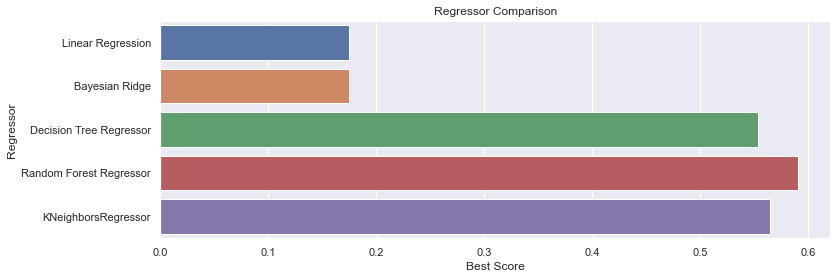

In [163]:
# Creamos el summary report
summary_cols = ['Best Score']
summary = pd.DataFrame.from_dict(models_result, orient='index')
summary.index.name = 'Regressor'
summary.columns = summary_cols
summary = summary.reset_index()

# Visualizamos los resultados
plt.figure(figsize=(12,4))
plt.xlabel('Best score')
plt.title('Regressor Comparison')

sns.barplot(x='Best Score', y='Regressor', data=summary)

### 6.7.2 - Predicciones

In [164]:
predventas = pd.DataFrame(prediction_RF) 
predventas.columns = ["Ventas"]
#predventas.to_csv("prediccion_resultados.csv") 

In [165]:
predventas

,Ventas
0,0.830297
1,3.150863
2,3.051814
3,34.738957
4,6.112071
...,...
70419,74.685541
70420,12.884144
70421,17.689517
70422,25.022515


Aquí tenemos las predicciones. Podríamos exportar los datos en formato CSV si fuera necesario.

## 6.8 - Automatización de modelo

Grid Search es una técnica usada para la selección de hiper-parámetros del entrenamiento de un modelo. Se realiza mediante los siguientes paramatros:

- estimados: el modelo que se ha de evaluar.
- param_grid: un diccionario donde se indican los parámetros a evaluar como clave y el conjunto elementos como valor.
- cv: el número de conjuntos en los que se divide los datos para la validación cruzada.

In [166]:
score_dict = {}
params_dict = {}
r2_dict = {}
best_est_dict = {}

In [167]:
# Parametros Grid - Random Forest Regressor
estimators_space = [100]
min_sample_splits = range(2,4)
min_sample_leaves = range(2,3)
param_grid_forest = dict(min_samples_split=min_sample_splits,
                       min_samples_leaf=min_sample_leaves,
                       n_estimators=estimators_space)
forest_model = RandomForestRegressor()

In [168]:
cv = 5

models_to_test = ['RandomForest']

regression_dict = dict(RandomForest=forest_model)
param_grid_dict = dict(RandomForest=param_grid_forest)

for model in models_to_test:
  regressor = GridSearchCV(regression_dict[model], param_grid_dict[model], cv=cv, n_jobs=-1)

  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)

  # Print tuned parametros y puntuación
  score_dict[model] = regressor.best_score_
  print("Tuned Parameters: {}".format(regressor.best_params_)) 
  r2_dict[model] = r2_score(y_test, y_pred)
  print("R2 score for {}".format(model))
  print(r2_score(y_test, y_pred))
  
  # Añadir mejor estimador al diccionario
  best_est_dict[model] = regressor.best_estimator_

Tuned Parameters: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
R2 score for RandomForest
0.5816695310300363


Hemos obtenido 0.58. Observamos que no mejora el resultado obtenido antes. 

En este caso, el resultado es de nuevo moderado, ya que el valor r2 está entre 0,5 y 0,7.

## 6.9 - Productivizar modelo

Al poductivizar el modelo, tenemos en primer lugar que definir claramente cual es el problema que se tiene que modelizar. Es importante para establecer un problema cuantificable. En nuestro caso, se trata de predecir las ventas: valores numéricos.

Asimismo, tenemos que desplegar el modelo en los servidores, garantizar una disponibilidad continua, así como el uso de APIs. Tenemos también que asegurar el control de accesos y la escalabilidad.

A continuación, vamos a poner un ejemplo de unas de las primera fases. Se trata de crear APIs en Python usando Flask.

In [169]:
# Trabajando con flask 
#from flask import flask
#app = Flask(__name__)
#@app.route(“/clasifica”, methods = [‘GET’, ‘POST’] )
#def clasifica(): 
#    pl = request.args.get(“pl”)
#    pw = request.args.get(“pw”)
#    sl = request.args.get(“sl”)
#    sw = request.args.get(“sw”)
#    resultados = xgboost_classify_iris(pl, pw, sl, sw) 
#    return resultados

In [170]:
# Correr un programa de pyton con flask 
#export FLASK_APP=clasifica.py
#python –m flask –un –host=0.0.0.0 –port=8080

In [171]:
# Llamar a un servicio python con flask desde un cliente   
#curl –data “sl=5.1&sw=3.5&pl=1.4&pw=0.3” \ ”http://modeloescalado:8080/clasifica”

# 7 - Conclusiones

Tras analizar los resultados, constatamos que nuestro modelo tiene una precisión de aproximadamente 60% - R2 = 0.59 - con Random Forest Regressor, para los datos de ventas del Reino Unido (UK). Sin embargo, los resultados de los primeros modelos son malos. Solo tres modelos tienen valores de R2 moderados. 

Podríamos añadir técnicas e intentar mejorar los resultados de las siguientes maneras:

* Hacer un análisis de clústeres y crear características basadas en los resultados.
* Obtener más información de las descripciones y números de 'StockCode'.
* Comparar ventas nacionales y internacionales.
* Probar modelos de deep learning.
* Cambiar el tuning de hiperparámetros de nuestros modelos y darle más tiempo para entrenar.